### Time-Series: Removing COVID from the BLS Jobs Dataset
The COVID pandemic resulted in a catastrophic dip in employment, recorded in the Bureau of Labor Statistics' (BLS) total employment dataset as of April 1st, 2020 (a few weeks after the lockdown began). 

This time-series anomaly has affected my MSA-ranking algorithm, as there is a sharp deceleration of job growth in 2020, then a sharp acceleration in 2021. This sharp acceleration in 2021 means that if I only want to analyze job growth from 2021, any MSA that recovered quickly in 2021 would then see a deceleration of job growth from 2021-2024, as no MSA could ever "grow" as quickly as they did during the 1-year post-COVID job-recovery period.

I am trying to measure and rank job growth acceleration across MSAs for purposes of real estate investment, and would therefore like to reduce (or remove) the impact COVID had on the deceleration-and-acceleration of job growth.

For simplicity, I will be deleting all data between April, 2020 and April, 2021, and using a time-series smoothing technique called interpolation to replace the data, using the previous years' information to "predict" what the employment numbers may have been if there was no pandemic.

A simple explanation of interpolation is that it calculates data in-between given values. So we will use the values pre-April 2020 and post-April 2021 to calculate the values between in a linear fashion to help "smoothen" the data.

In [2]:
import sys
import re
import requests
import json
import asyncio
import nest_asyncio
import aiohttp
import time
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Suppress unnecessary Shapely warning
warnings.filterwarnings('ignore',
                        '.*Shapely GEOS version.*')

from aiohttp import ClientSession
from requests import request, Session
from itertools import product, repeat
import os
from dotenv import load_dotenv
from os import getenv
from threading import Thread
import time
import inspect
import pandas as pd
import geopandas as gp
import shapely
import pygeos
from functools import reduce
from pandas.plotting import lag_plot
import pickle
import numpy as np
import seaborn as sns
import datetime as dt
import copy
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from multiprocess import Process, Pool

from sklearn.linear_model import LinearRegression, Ridge

# Set up Pandas defaults
pd.options.display.float_format = '{:.6f}'.format
pd.set_option("display.max_columns", None)



In [3]:
# Create helpful cleaning functions
def clean_BLS_msa_names(dataframe):
    """
    This functions standardizes the MSA names
    between the BLS dataset and the Zillow
    datasets by only taking the first city
    within a BLS-MSA with a "-" hyphenate, 
    and the first state with a "-" hyphenate.
    
    For example: 'Houston-The Woodlands-Sugar Land, TX'
    will be turned into just 'Houston, TX' and
    'Cincinnati, OH-KY-IN' will be turned into
    just 'Cincinnati, OH'.
    """
    
    df = dataframe.copy()
    
    # Get the state column
    df['state'] = df['msa_name'].str.split(', ').str[1].str.strip()
    df['state'] = df['state'].str.split('-').str[0].str.strip()
    
    # Get the first city name
    df['city'] = df['msa_name'].str.split(', ').str[0].str.strip()
    df['city'] = df['city'].str.split('-').str[0].str.strip()
    
    # Get msa name
    df['msa_name'] = df['city'] + ", " + df['state']
    
    return df

In [8]:
# Read in most recent job data
jobs = pd.read_csv('../datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

# Make sure the date column is in datetime format
jobs['date'] = pd.to_datetime(jobs['date'])

# Replace NECTA Division
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

# Standardize MSA names
jobs = clean_BLS_msa_names(jobs)

# Only keep select columns
jobs = jobs[['msa_code','msa_name','year','date','value']]

jobs

msa_code     msa_name  year       date        value
0        10180  Abilene, TX  2024 2024-03-01 77400.000000
1        10180  Abilene, TX  2024 2024-02-01 77300.000000
2        10180  Abilene, TX  2024 2024-01-01 77200.000000
3        10180  Abilene, TX  2023 2023-12-01 77100.000000
4        10180  Abilene, TX  2023 2023-11-01 77400.000000
...        ...          ...   ...        ...          ...
43285    49740     Yuma, AZ  2015 2015-05-01 53100.000000
43286    49740     Yuma, AZ  2015 2015-04-01 53000.000000
43287    49740     Yuma, AZ  2015 2015-03-01 52800.000000
43288    49740     Yuma, AZ  2015 2015-02-01 53000.000000
43289    49740     Yuma, AZ  2015 2015-01-01 53000.000000

[43290 rows x 5 columns]

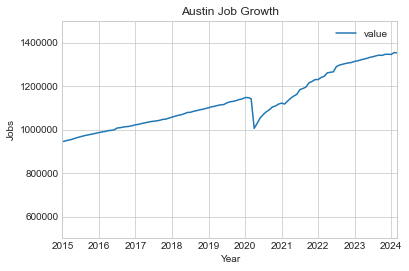

In [291]:
### EDA ONLY - KEEP ONLY TO DOCUMENT
austin = jobs[jobs['msa_name'].str.contains('Austin, TX')].copy()
austin = austin[['date','value']]
austin = austin.set_index('date')

### TESTING
austin_smooth = austin.copy()

### PLOT THE BEFORE SMOOTHING AND AFTER SMOOTHING
fig, ax = plt.subplots()
ax = austin.plot(ylim=(500_000, 1_500_000), 
            ylabel='Jobs', 
            xlabel='Year',
                 title='Austin Job Growth',
           ax=ax)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

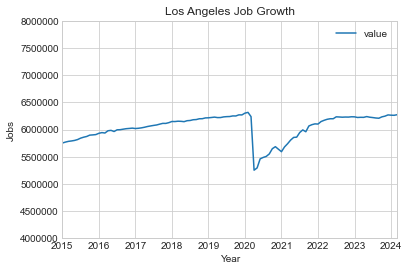

In [290]:
### EDA ONLY - KEEP ONLY TO DOCUMENT
angeles = jobs[jobs['msa_name'].str.contains('Los Angeles')].copy()
angeles = angeles[['date','value']]
angeles = angeles.set_index('date')

### TESTING
angeles_smooth = angeles.copy()

### PLOT THE BEFORE SMOOTHING AND AFTER SMOOTHING
fig, ax = plt.subplots()
ax = angeles.plot(ylim=(4_000_000, 8_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
                 title='Los Angeles Job Growth',
           ax=ax)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [164]:
# Test with Los Angeles
smooth_jobs = jobs.copy()
smooth_jobs = smooth_jobs[['msa_name','date','value']]
smooth_jobs = smooth_jobs.set_index(['msa_name'])
los_ang = smooth_jobs.loc['Los Angeles, CA'].copy()

# Create dummy column
los_ang['dummy'] = los_ang['value']

# Filter and replace with NaNs
mask = (los_ang['date']<='2021-04-01') & (los_ang['date']>='2020-04-01')
los_ang.loc[mask, 'dummy'] = np.nan

# Use interpolation now
los_ang['interpolated'] = los_ang['dummy'].interpolate(method='linear')

# Drop dummy column
los_ang.drop(columns=['dummy'], inplace=True)

In [225]:
def interpolate_smoothen(
    dataframe, 
    msa_name,
    end_date='2021-04-01',
    start_date='2020-04-01'
):
    """
    This function adds an "interpolated" column in which
    the job numbers between the start_date and end_date
    are linearly interpolated. The purpose of this function
    is to give the user a column in which the impact of
    COVID on job deceleration and acceleration has been
    smoothed.
    """
    
    smooth_jobs = dataframe.copy()
    smooth_jobs = smooth_jobs[['msa_name','date','value']]
    msa = smooth_jobs[smooth_jobs['msa_name']==msa_name].copy()

    # Create dummy column
    msa['dummy'] = msa['value']

    # Filter and replace with NaNs
    mask = (msa['date']<=end_date) & (msa['date']>=start_date)
    msa.loc[mask, 'dummy'] = np.nan

    # Use interpolation now
    msa['interpolated'] = msa['dummy'].interpolate(method='linear')

    # Drop dummy column
    msa.drop(columns=['dummy'], inplace=True)
    
    return msa

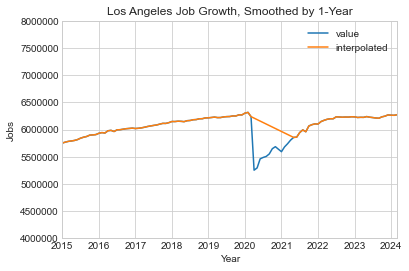

In [294]:
# Test with Los Angeles
los_ang = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Los Angeles, CA',
    end_date='2021-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
los_ang_smooth = los_ang.set_index('date').copy()

### PLOT THE BEFORE SMOOTHING AND AFTER SMOOTHING
fig, ax = plt.subplots()

ax = los_ang_smooth.plot(ylim=(4_000_000, 8_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Los Angeles Job Growth, Smoothed by 1-Year',
            ax=ax)

plt.ticklabel_format(style='plain', axis='y')

plt.show()

As you can see, for Los Angeles, having only one year be smoothed isn't quite enough to smooth our data. Let's test this one-year approach for a few other cities first before lengthening the amount of smoothing we might want.

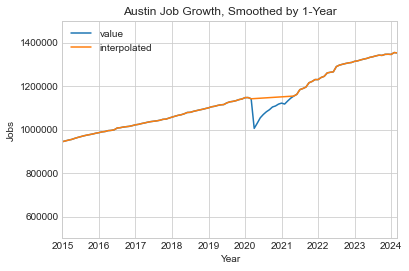

In [293]:
# Test with Austin, TX
austin = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Austin, TX',
    end_date='2021-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
austin_smooth = austin.set_index('date').copy()

### PLOT THE BEFORE SMOOTHING AND AFTER SMOOTHING
fig, ax = plt.subplots()

ax = austin_smooth.plot(ylim=(500_000, 1_500_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Austin Job Growth, Smoothed by 1-Year',
            ax=ax)

plt.ticklabel_format(style='plain', axis='y')

plt.show()

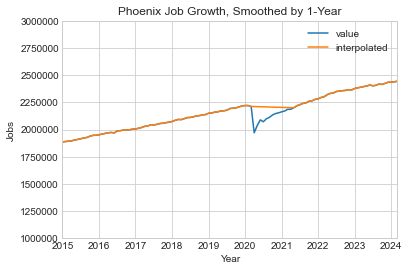

In [297]:
# Test with Phoenix
phoenix = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Phoenix, AZ',
    end_date='2021-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
phoenix_smooth = phoenix.set_index('date').copy()

### PLOT THE BEFORE SMOOTHING AND AFTER SMOOTHING
fig, ax = plt.subplots()

ax = phoenix_smooth.plot(ylim=(1_000_000, 3_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Phoenix Job Growth, Smoothed by 1-Year',
            ax=ax)

plt.ticklabel_format(style='plain', axis='y')

plt.show()

Now let's try smoothing by 2 full years. The obvious tradeoff to this approach is essentially losing 2 years worth of real-world data. The potential benefit is a dataset where the pandemic has been smoothed over.

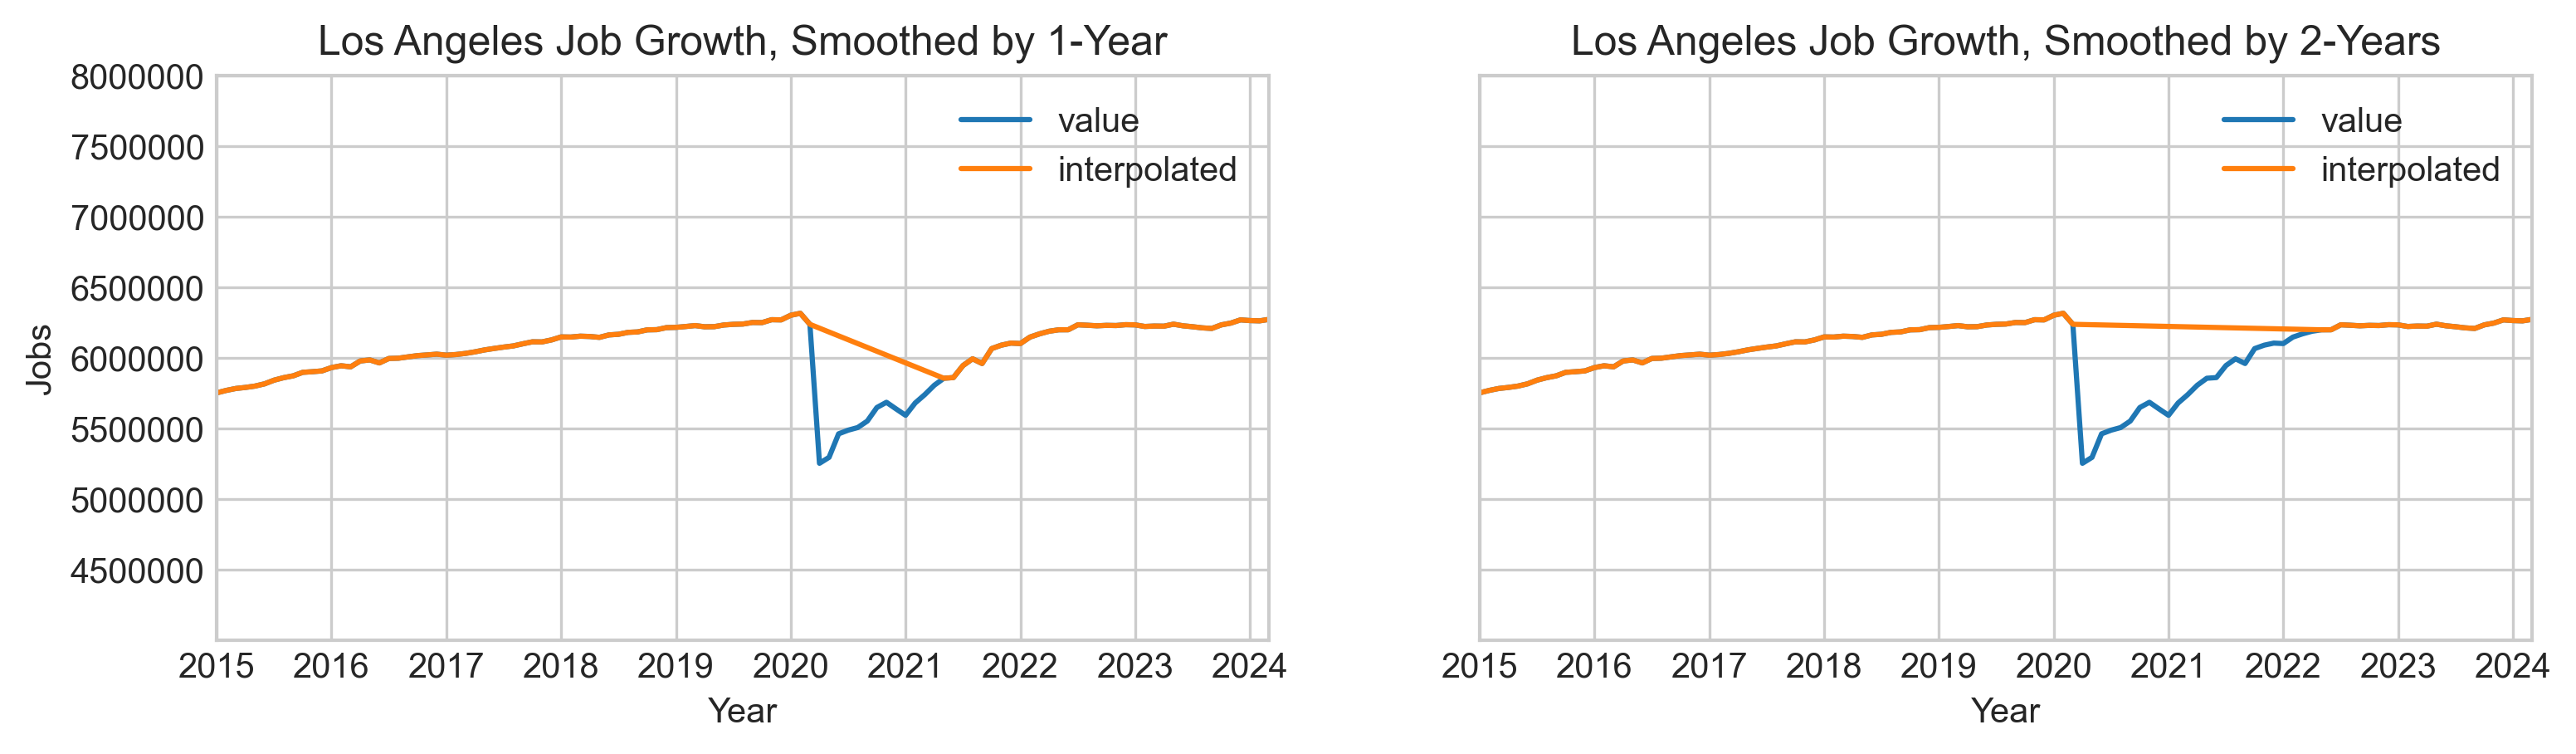

In [309]:
# Test with Los Angeles
los_ang_more = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Los Angeles, CA',
    end_date='2022-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
los_ang_more_smooth = los_ang_more.set_index('date').copy()


# Make a grid to plot 2 graphs on
fig = plt.figure(figsize=(12,3), dpi=300)
gs = GridSpec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1, ax2]

# The original smoothing
ax = los_ang_smooth.plot(ylim=(4_000_000, 8_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Los Angeles Job Growth, Smoothed by 1-Year',
            ax=ax1)

ax1.ticklabel_format(style='plain', axis='y')

# The new smoothing
ax = los_ang_more_smooth.plot(ylim=(4_000_000, 8_000_000), 
#             ylabel='Jobs', 
            xlabel='Year',
            title='Los Angeles Job Growth, Smoothed by 2-Years',
            ax=ax2)

ax2.ticklabel_format(style='plain', axis='y')

ax1.get_yticklabels()[0].set_visible(False)
ax2.yaxis.set_tick_params(labelleft=False)


plt.show()

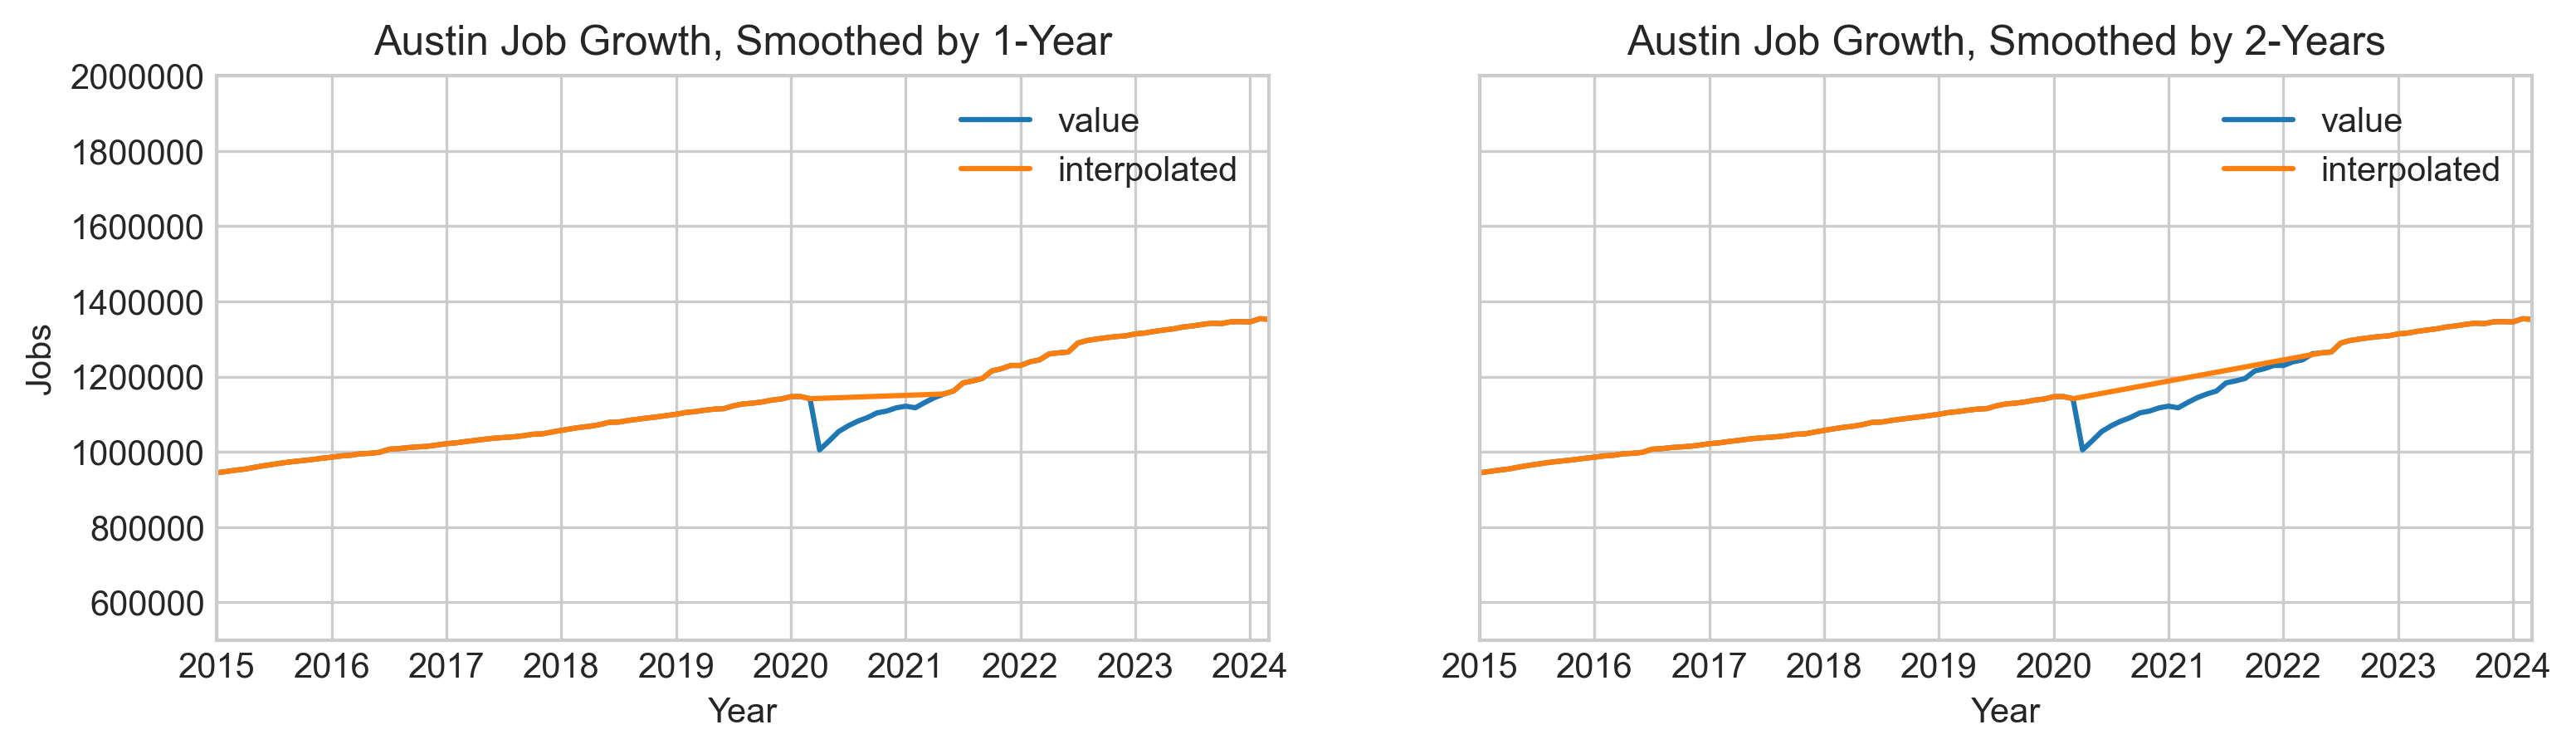

In [310]:
# Test with Austin
austin_more = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Austin, TX',
    end_date='2022-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
austin_more_smooth = austin_more.set_index('date').copy()


# Make a grid to plot 2 graphs on
fig = plt.figure(figsize=(12,3), dpi=300)
gs = GridSpec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1, ax2]

# The original smoothing
ax = austin_smooth.plot(ylim=(500_000, 2_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Austin Job Growth, Smoothed by 1-Year',
            ax=ax1)

ax1.ticklabel_format(style='plain', axis='y')

# The new smoothing
ax = austin_more_smooth.plot(ylim=(500_000, 2_000_000), 
#             ylabel='Jobs', 
            xlabel='Year',
            title='Austin Job Growth, Smoothed by 2-Years',
            ax=ax2)

ax2.ticklabel_format(style='plain', axis='y')

ax1.get_yticklabels()[0].set_visible(False)
ax2.yaxis.set_tick_params(labelleft=False)


plt.show()

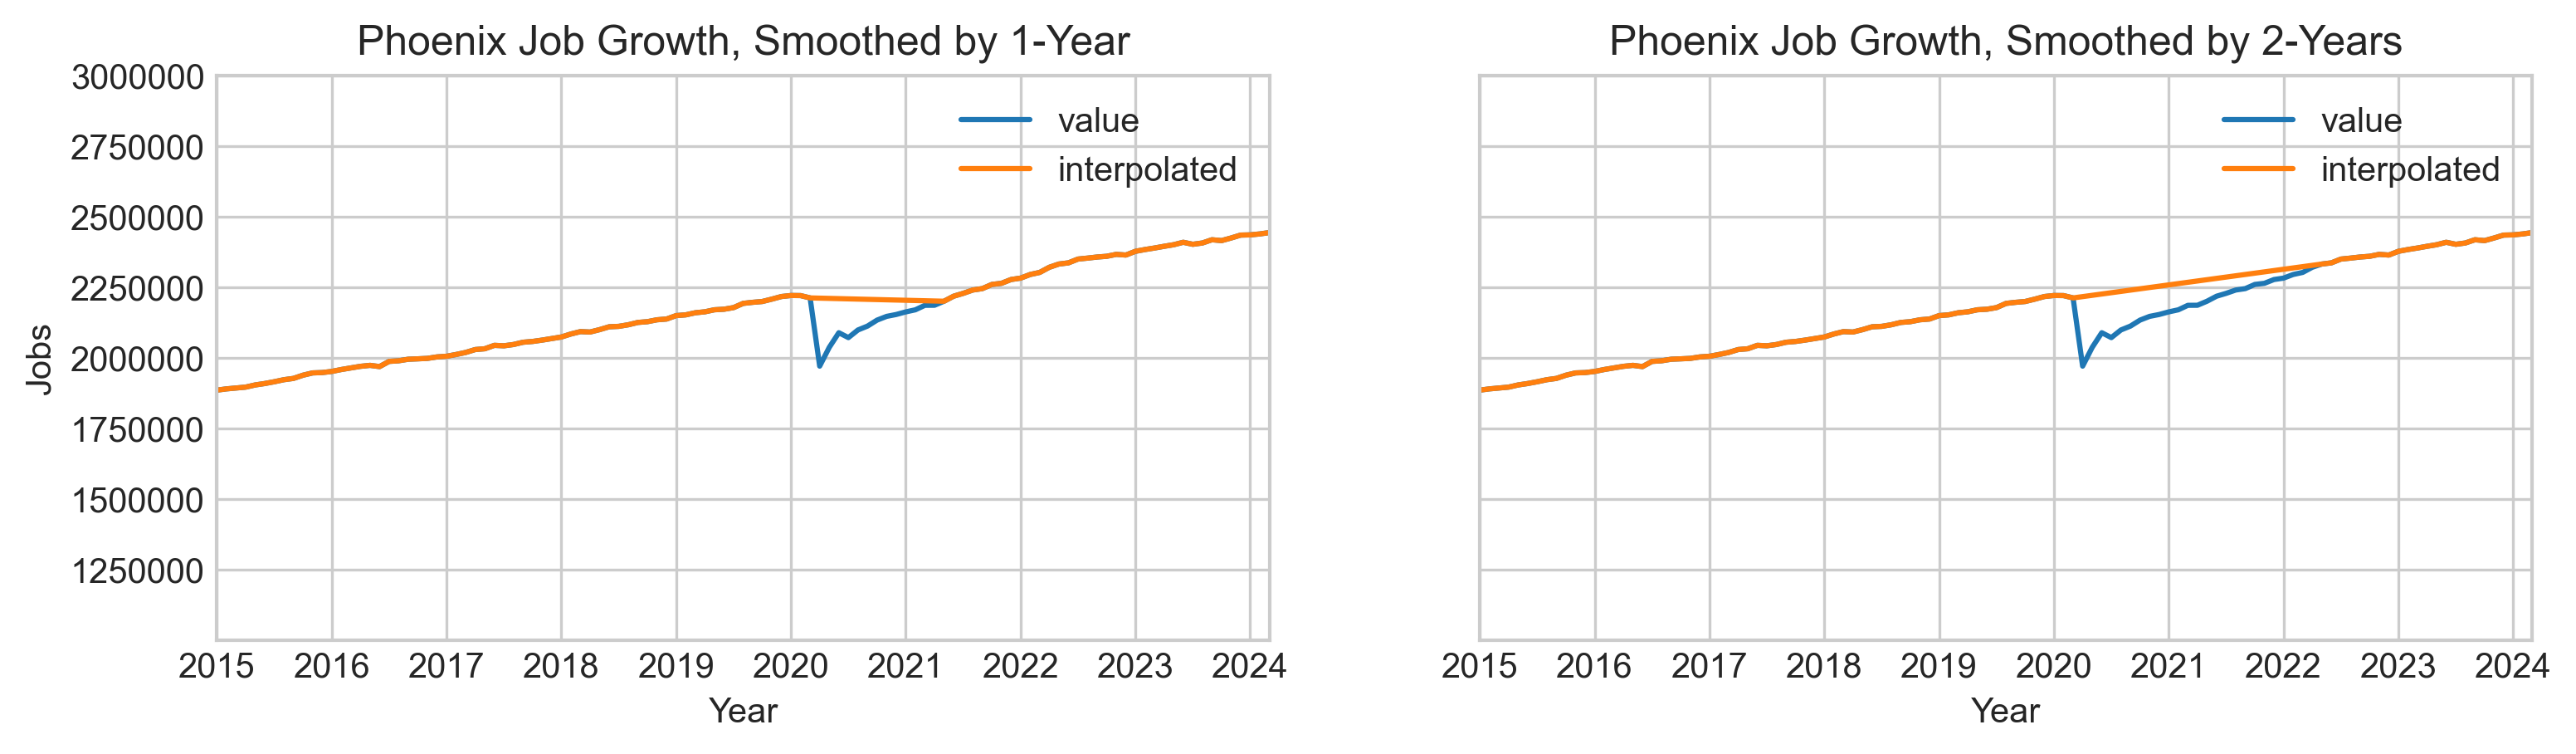

In [311]:
# Test with Phoenix
phoenix_more = interpolate_smoothen(
    dataframe=jobs, 
    msa_name='Phoenix, AZ',
    end_date='2022-04-01',
    start_date='2020-04-01'
)

# Prepare for plotting
phoenix_more_smooth = phoenix_more.set_index('date').copy()



# Make a grid to plot 2 graphs on
fig = plt.figure(figsize=(12,3), dpi=300)
gs = GridSpec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1, ax2]

# The original smoothing
ax = phoenix_smooth.plot(ylim=(1_000_000, 3_000_000), 
            ylabel='Jobs', 
            xlabel='Year',
            title='Phoenix Job Growth, Smoothed by 1-Year',
            ax=ax1)

ax1.ticklabel_format(style='plain', axis='y')

# The new smoothing
ax = phoenix_more_smooth.plot(ylim=(1_000_000, 3_000_000), 
#             ylabel='Jobs', 
            xlabel='Year',
            title='Phoenix Job Growth, Smoothed by 2-Years',
            ax=ax2)

ax2.ticklabel_format(style='plain', axis='y')

ax1.get_yticklabels()[0].set_visible(False)
ax2.yaxis.set_tick_params(labelleft=False)


plt.show()

While this smoothing removes any explosive growth a city may have had between 2020-2022, it also tries its best to remove any impact COVID had on the data to begin with, which aligns with our original intention. We will move forward with ensuring all job numbers between April 2020 and April 2022 are replaced with a linear interpolation (a prediction) of what their numbers may have been if COVID never happened.

In [239]:
### Let's create a function that loops through every 
### city and interpolates April 2020 - April 2022,
### and then saves this dataset for future use.

# Define helper function to create directory
def create_folder(the_path):
    if not os.path.isdir(the_path):
        os.mkdir(the_path)

def interpolate_all_msa_job_data():
    
    # Call in the original job dataset
    jobs = pd.read_csv('../datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

    # Make sure the date column is in datetime format
    jobs['date'] = pd.to_datetime(jobs['date'])

    # Replace NECTA Division
    jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
    jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

    # Standardize MSA names
    jobs = clean_BLS_msa_names(jobs)
    
    # Add new column
    jobs['interpolated'] = np.nan
    
    # Loop through all MSAs
    for msa in jobs['msa_name'].unique():
    
        # Smoothen the data at the MSA level
        smooth_msa = interpolate_smoothen(
            dataframe=jobs, 
            msa_name=msa,
            end_date='2022-04-01',
            start_date='2020-04-01')
        
        # Create a mask
        mask = jobs['msa_name'] == msa

        # Add the interpolated data to the original jobs dataframe
        jobs.loc[mask, 'interpolated'] = smooth_msa['interpolated']
    

    # Create folder to save covid-smoothed dataset
    folder_name = '../datasets/bls/smoothed'
    create_folder(folder_name)
    
    # Create filename
    filename = f"{folder_name}/most_recent_bls_covid_smoothed.csv"
    
    # Save file
    jobs.to_csv(filename, index=False)
    
    
interpolate_all_msa_job_data()
    

## For EDA and Verification Only, Include Plotting Function Below

In [240]:
# Define helper function that runs linear regression
def run_lr(df, column):
    """
    Run linear regression on time-series data 
    and return the coefficient and intercept.
    
    Arguments
    -----------
        df (DataFrame): A dataframe that contains the
            target column and an 'ordinal_date' column
            that was created by a time-series column in 
            the format of "%Y-%m-%d" and making it ordinal,
            such as running the code below in some other 
            step. 
            
            EXAMPLE...
            # Create ordinal column
            df['ordinal_date'] = df['date'].map(
                datetime.toordinal)
                
        column (str): The name of the target column.
            
    Returns
    -----------
        coef (float): The coefficient of the linear
            equation calculated.
        
        intercept (float): The y-intercept of the linear
            equation calculated.
    
    """
    # Run linear regression
    normal_lr = LinearRegression()
    X = df[['ordinal_date']]
    y = df[column]
    normal_lr.fit(X, y)
    coef = normal_lr.coef_[0]
    intercept = normal_lr.intercept_

    # Return lr coefficient
    return coef, intercept

In [265]:
# Loop through all cities, sort by coefficient, plot top 10
def plot_top_10_cities(
    ranked_cities,
    plot_jobs=False,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2013,
    end_year_1=False,
    plot_all=False,
    column_to_use='column'
):
    """
    Plots the top cities for a given demographic. Top cities
    are chosen based on their trend. This function can also 
    find the top cities based on multiple datasets.
    
    Arguments
    ----------
        ranked_cities (DataFrame): A dataframe of cities
            already ranked by various demographics. The
            dataframe returned by the "make_ranking()"
            function is the ideal dataframe to pass
            to this function.
            
        plot_jobs (True/False): If Ture, plot jobs. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_rent (True/False): If Ture, plot rent. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_income (True/False): If Ture, plot income. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_price (True/False): If Ture, plot price. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_units (True/False): If Ture, plot units. Only one 
            demographic can be plotted at a time, so if you'd 
            like to plot a different demographic, this must 
            be set to False.
        
        plot_rent_to_price (True/False): If Ture, plot rent-ro-price
            ratio. Only one demographic can be plotted at a time, 
            so if you'd like to plot a different demographic, 
            this must be set to False.
        
        plot_jobs_per_unit (True/False): If Ture, plot jobs-per-unit. 
            Only one demographic can be plotted at a time, so if 
            you'd like to plot a different demographic, this must 
            be set to False.
            
        begin_year_1 (int): The year you'd like the
            analysis to start.
            
        plot_all (True/False): True if you want to plot every
            city in the dataframe (slow). False if you only want
            to plot the top 5 (fast).
    
    Returns
    ----------
        coef_df (DataFrame): A dataframe with the rankings
            of each city, from "best to worst."
    
    """
    # Make a copy of the ranked cities
    ranked = ranked_cities.copy()
    
    # If not plotting all cities (and just top 10),
    # keep only the top 10 cities in the dataframe
    if not plot_all:
        ranked = ranked.head(10)
    
    ### Call in the dataset we will be graphing from
    
    # If plotting job growth
    if plot_jobs:
        
        # Set demographic title for graphs
        demographic_1="Job"
        
        # Read in most recent job data
        dataframe_1 = pd.read_csv('../datasets/bls/smoothed/most_recent_bls_covid_smoothed.csv',
                           dtype={'msa_code':str, 'state_code':str})

        # Make sure the date column is in datetime format
        dataframe_1['date'] = pd.to_datetime(dataframe_1['date'])
        
        # Clean the BLS msa names
        dataframe_1 = clean_BLS_msa_names(dataframe_1)

        # Replace NECTA Division
        dataframe_1['msa_name'] = dataframe_1['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
        dataframe_1['msa_name'] = dataframe_1['msa_name'].apply(lambda x: x.replace(" NECTA",""))
    
    # Otherwise, print error statement
    else:
        print("Please specify a demographic to plot by setting it to True, and leaving the others set to False.")
        raise Exception("SPECIFY A DEMOGRAPHIC TO PLOT.")
    
    # Make copy
    main_df = dataframe_1.copy()
            
    # Create main variable to use for the rest of the script
    column = column_to_use

    # Create dictionary to store filtered dataframes
    filtered_dict = {}

    # Set y_lim list to find max and min
    y_lim_list_trend = []
    y_min_list_trend = [0]
    y_lim_list_pct = []
    y_min_list_pct = [0]
    
    # Loop through all cities in the ranked dataframe
    for city in ranked['msa_name'].dropna().unique():

        # Isolate just that city
        df = main_df[main_df['msa_name']==city].copy()
        
        # Sort by date
        df = df.sort_values('date')
                
        # Create difference column
        df['value_change'] = df[column].diff()
        
        # Create pct_change column
        df['percent_change'] = df[column].pct_change()
                
        # Filter by beginning year
        df = df[df['year']>=begin_year_1].reset_index(drop=True)
        
        if end_year_1:
            df = df[df['year']<=end_year_1].reset_index(drop=True)
                
        # If an MSA's most recent year is after the beginning
        # year, remove it from the graphs. For example, if we want to
        # view the growth of all cities since 2016, but Prescott Valley
        # only has data starting at 2019, this may skew the data.
        if df['year'].iloc[0] != begin_year_1:
            print(f"Dropping {city}, it's dataframe has a smaller window.")
            continue
                
        # Remove NaN values
        df = df[df['percent_change'].notna()]
        
        # Isolate date and value columns
        df = df[[
            'date', column, 'value_change',
            'percent_change']].reset_index(drop=True)
        
        # Add this dataframe's y_lim to list
        y_lim_list_trend.append(df[column].max())
        y_min_list_trend.append(df[column].min())
        y_lim_list_pct.append(df['percent_change'].max())
        y_min_list_pct.append(df['percent_change'].min())
        
        # get next months's datetime
        next_year = df['date'].iloc[-1] + relativedelta(months=1)
        
        # Create ordinal column
        df['ordinal_date'] = df['date'].map(datetime.toordinal)
        
        # Run linear regression and get the trend's coefficient
        coef_value, intercept_value = run_lr(df, column=column)
        coef_pct, intercept_pct = run_lr(df, column='percent_change')
        
        # Create next year's date
        df.loc[len(df.index)] = [
            next_year, np.nan, np.nan, 
            np.nan, datetime.toordinal(next_year)]
        
        # Create averages column
        the_average_pct = df['percent_change'].mean()
        df['average_pct'] = the_average_pct
        the_average_value = df['value_change'].mean()
        df['average_value'] = the_average_value

        # Fill in with linear regression values.
        # Also add highest trend value to lim_list.
        df['value_trend'] = df['ordinal_date']*coef_value + intercept_value
        df['percent_change_trend'] = df['ordinal_date']*coef_pct + intercept_pct

        # Also add highest trend value to lim_list
        y_lim_list_trend.append(df['value_trend'].max())
        y_lim_list_pct.append(df['percent_change_trend'].max())

        # Get the y_lim
        y_lim_trend = max(y_lim_list_trend) * 1.1
        y_min_trend = min(y_min_list_trend)
        y_lim_pct = max(y_lim_list_pct) * 1.1
        y_min_pct = min(y_min_list_pct)
            
        # Save filtered data to dictionary
        filtered_dict[city] = df
    
    # Loop through each city in the ranked df
    for city_name in ranked['msa_name']:

        # Get the job data
        df = filtered_dict[city_name]    
            
        # Make a grid to plot 2 graphs on
        fig = plt.figure(figsize=(12,3), dpi=300)
        gs = GridSpec(nrows=1, ncols=2)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax_list = [ax1, ax2]
        
        # Set grid
        plt.style.use('seaborn-whitegrid')

        # Set title
        fig.suptitle(f"{city_name}\n\n\n", 
             fontweight="bold")

        # Plot first graph
        ax1 = df.plot(x='date',y=column, ax=ax1)
#         ax1 = df.plot(x='date',y='value_trend', ax=ax1, linestyle="--")

        # Plot second graph
        ax2 = df.plot(x='date',y='percent_change', ax=ax2)
        ax2 = df.plot(x='date',y='percent_change_trend', ax=ax2, linestyle="--")

        # Second graph's zero line
        df['zero'] = 0
        ax2 = df.plot(x='date', y='zero', ax=ax2, color="grey")

        # Also plot the average line
        ax2 = df.plot(x='date', y='average_pct', 
                      ax=ax2, color="black", linestyle="-")

        # Set title's for both graphs
        ax1.set_title(f"{demographic_1} Growth")
        ax2.set_title(f"Percent Change in {demographic_1}s")

        # Set y lims and y ticks
        ax1.set_ylim([y_min_trend, y_lim_trend])
        ax2.set_ylim([y_min_pct, y_lim_pct])

        # Set y limits
        y_tick_list_trend = [
            y_lim_trend*0.25, y_lim_trend*0.5, 
            y_lim_trend*0.75, y_lim_trend]
        y_tick_list_pct = [
            y_min_pct, y_min_pct*0.5, 0, 
            y_lim_pct*0.5, y_lim_pct]

        # Set y_ticks
        ax1.yaxis.set_major_locator(
            mticker.FixedLocator(y_tick_list_trend))
        ax2.yaxis.set_major_locator(
            mticker.FixedLocator(y_tick_list_pct))

        # Set y-tick labels
        ax1.set_yticklabels(
            ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_trend])
        ax2.set_yticklabels(
            ['{:,}'.format(round(float(x), 3)) for x in y_tick_list_pct])
        
        # Give suptitle more room
        fig.subplots_adjust(top=0.85)

        # Create folder to save graphs into
#         create_folder("graphs")
#         create_folder("graphs/msa_graphs")
#         create_folder(f"graphs/msa_graphs/{city_name}")

        # Create filepath to save graph to
#         save_filepath = f"graphs/msa_graphs/{city_name}/{demographic_1} Growth.png"

        # Save the graphs
#         plt.savefig(save_filepath)
        
        # Show plot
        plt.show()
        
        # Clear plot
        plt.close("all")


In [331]:
# Create testing dataframe for bigger cities
plot_big_jobs = pd.DataFrame(jobs[
    jobs['msa_name'].str.contains(
        """Los Angeles|Dallas|Houston|Phoenix"""
    )
]['msa_name'].unique(), columns=['msa_name'])

plot_big_jobs

msa_name
0       Dallas, TX
1      Houston, TX
2  Los Angeles, CA
3      Phoenix, AZ

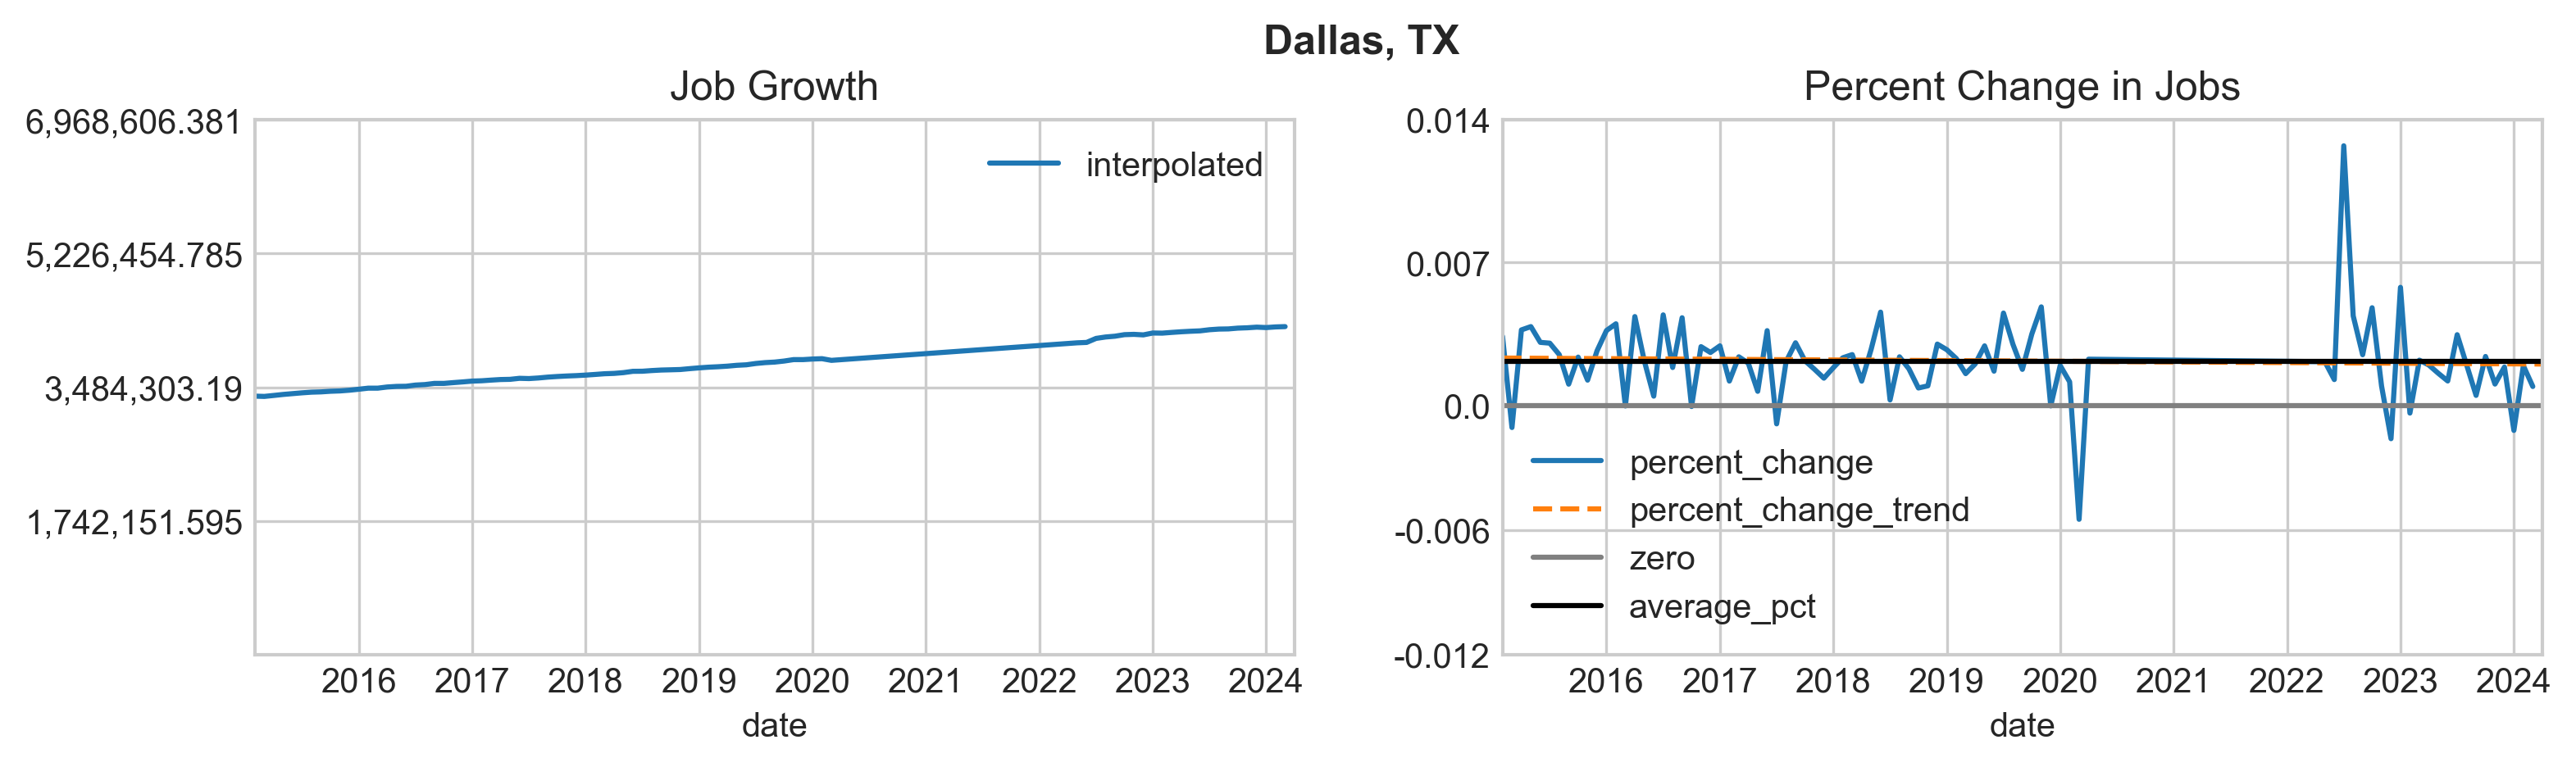

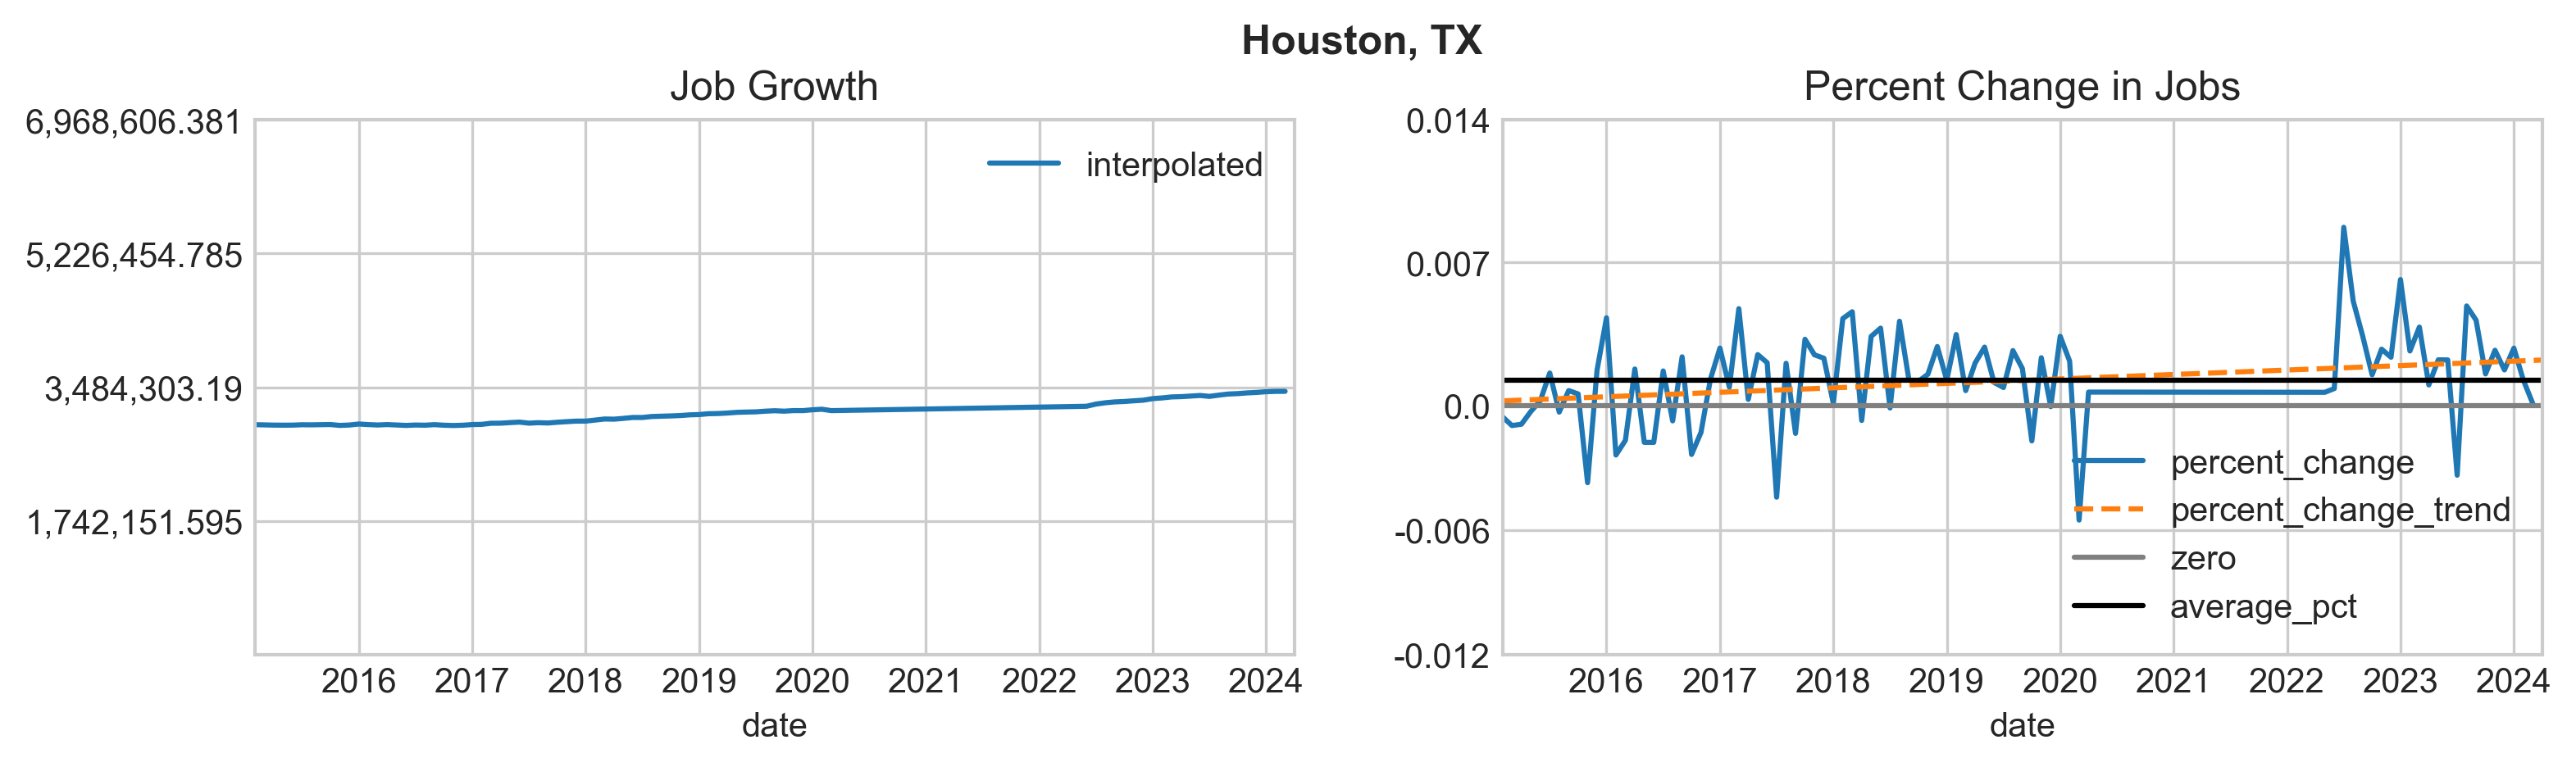

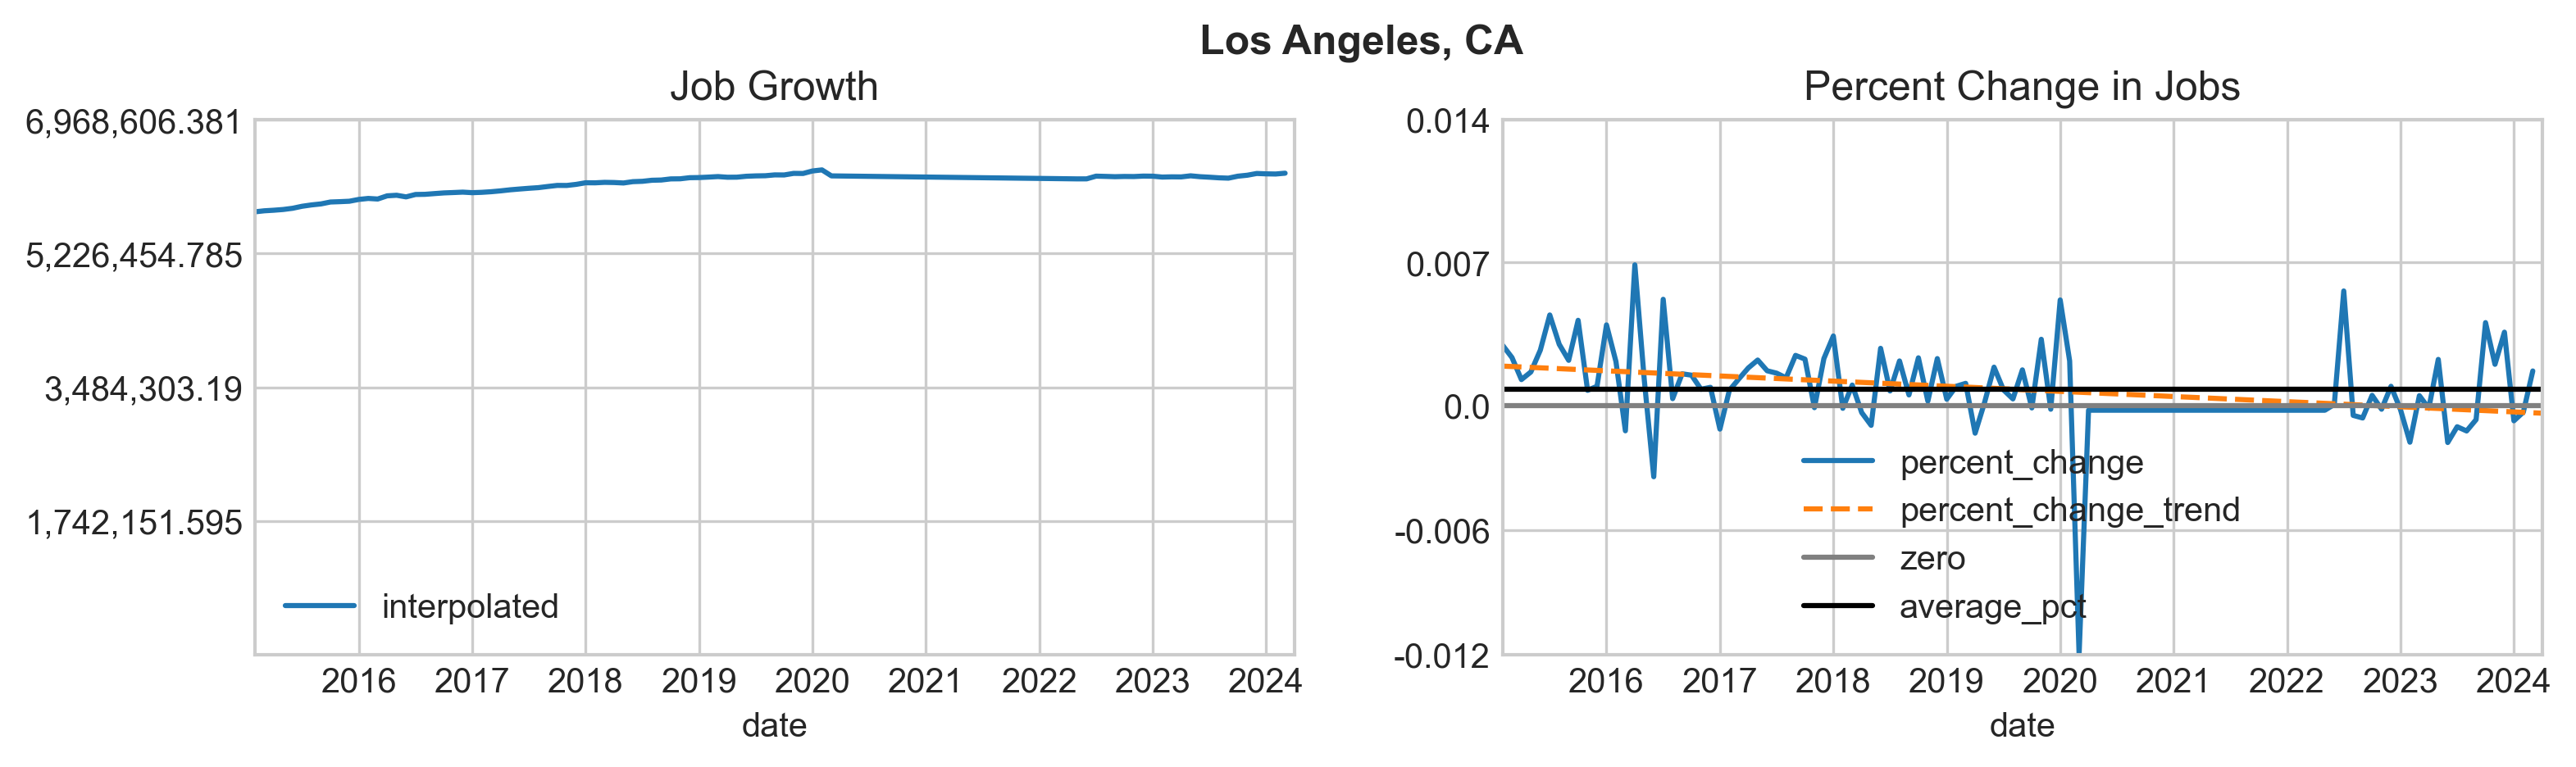

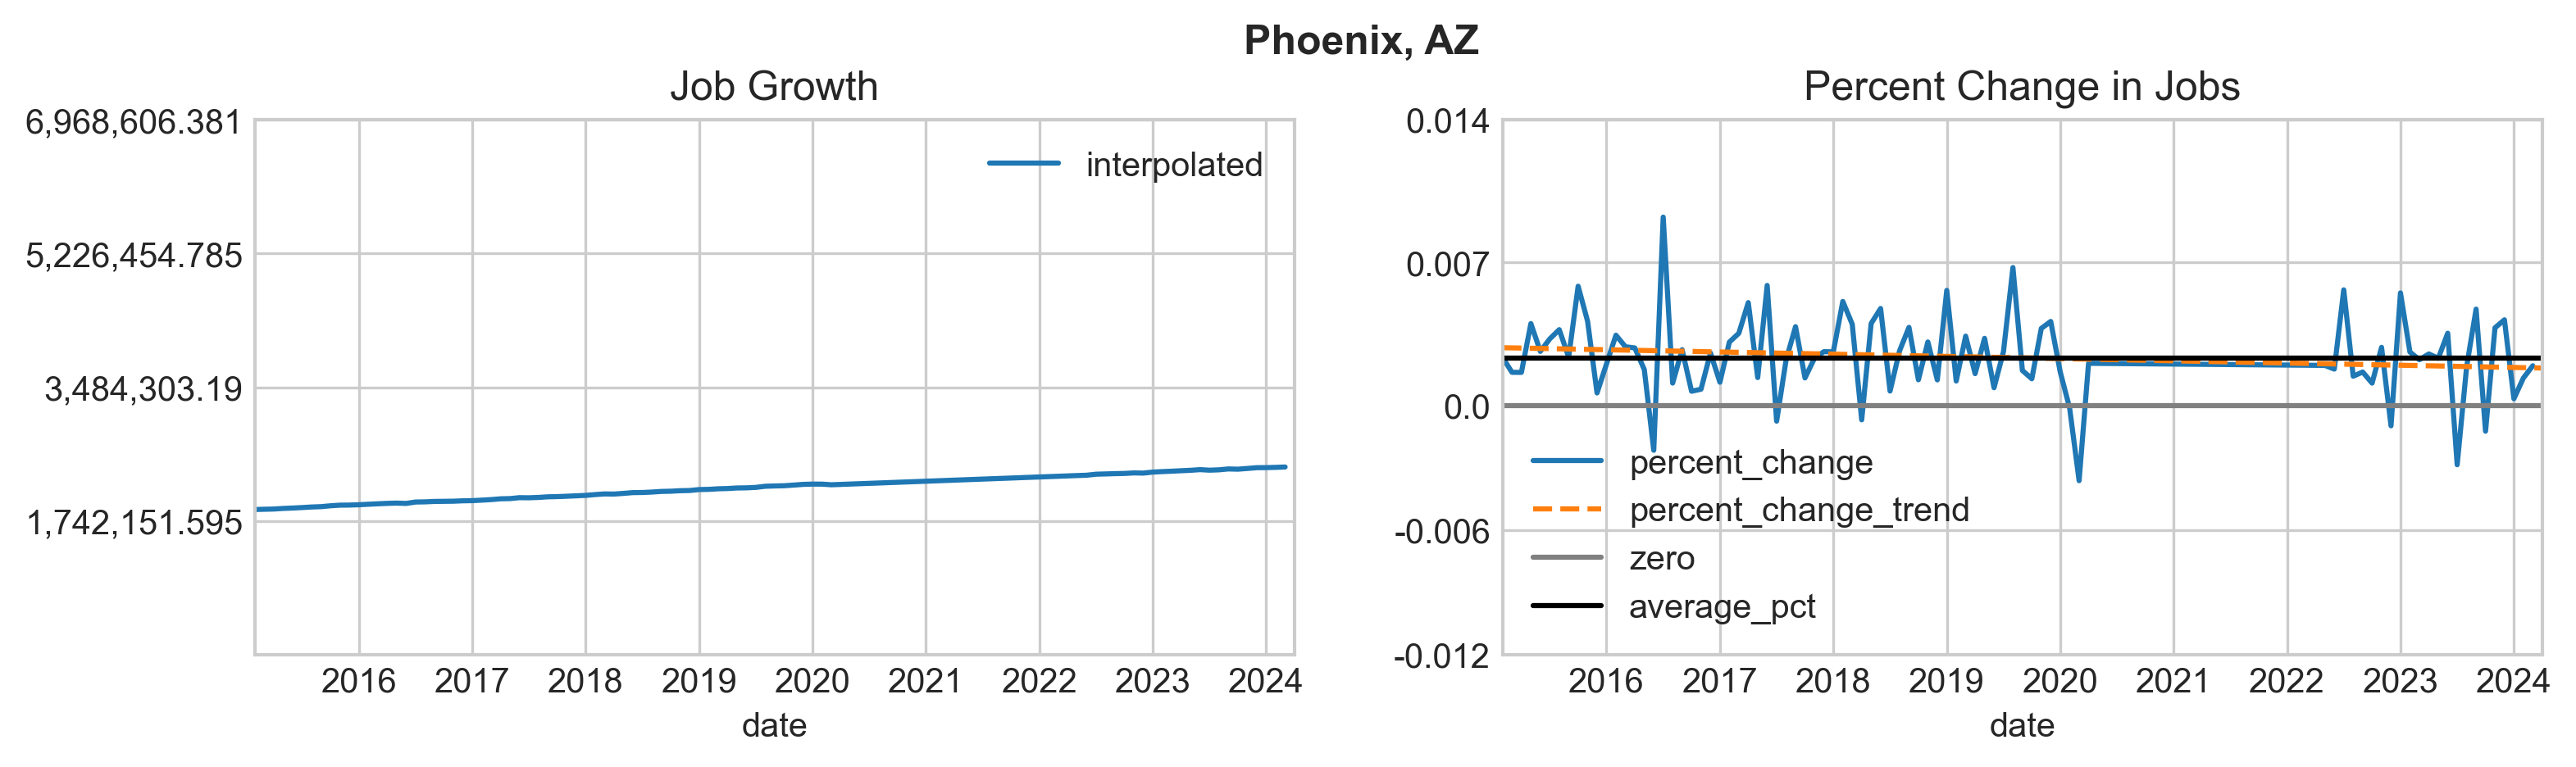

In [332]:
plot_top_10_cities(
    plot_big_jobs,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2015,
    end_year_1=2024,
    plot_all=True,
    column_to_use='interpolated'
)

In [329]:
# Create testing dataframe
plot_these_jobs = pd.DataFrame(jobs[
    jobs['msa_name'].str.contains(
        """Austin|Denver|
        |Riverside, CA|Atlanta|
        |Nashville|Charleston, SC|Indianapolis|Las Vegas|
        |Knoxville"""
    )
]['msa_name'].unique(), columns=['msa_name'])

plot_these_jobs

msa_name
0       Atlanta, GA
1        Austin, TX
2    Charleston, SC
3        Denver, CO
4  Indianapolis, IN
5     Knoxville, TN
6     Las Vegas, NV
7     Nashville, TN
8     Riverside, CA

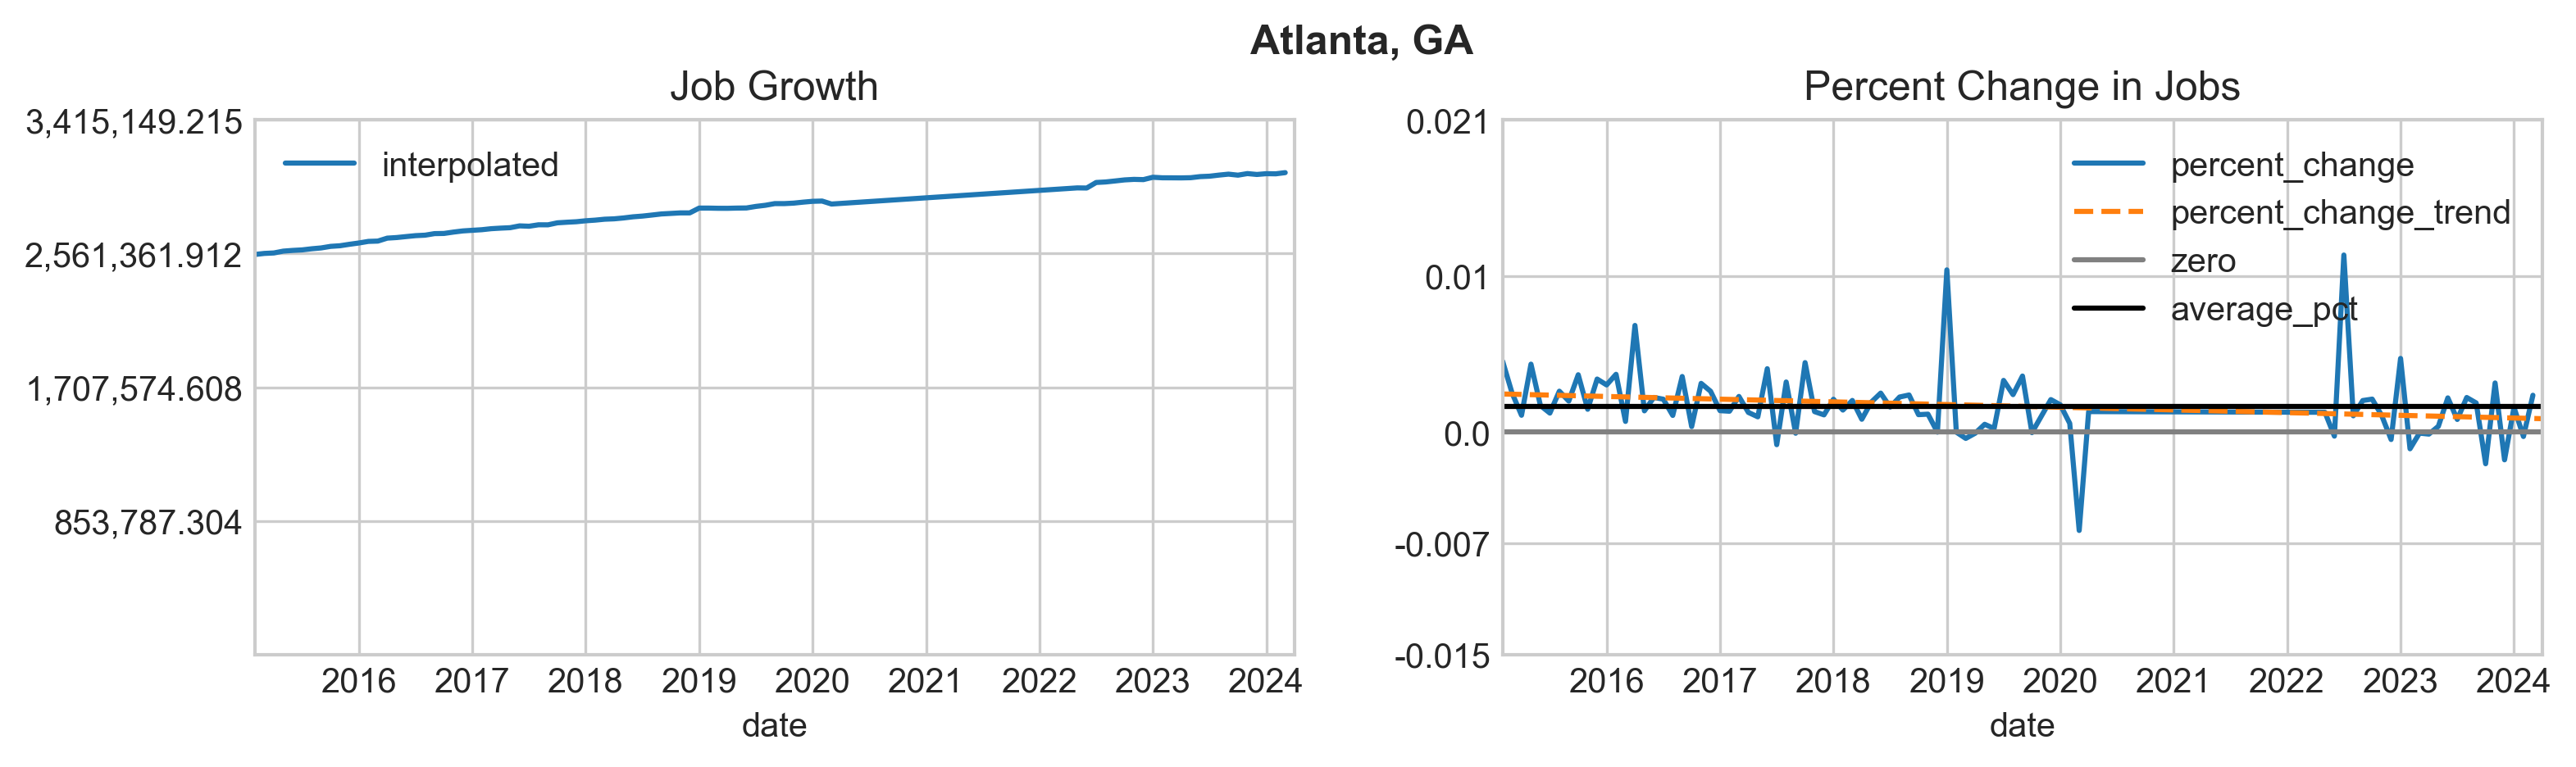

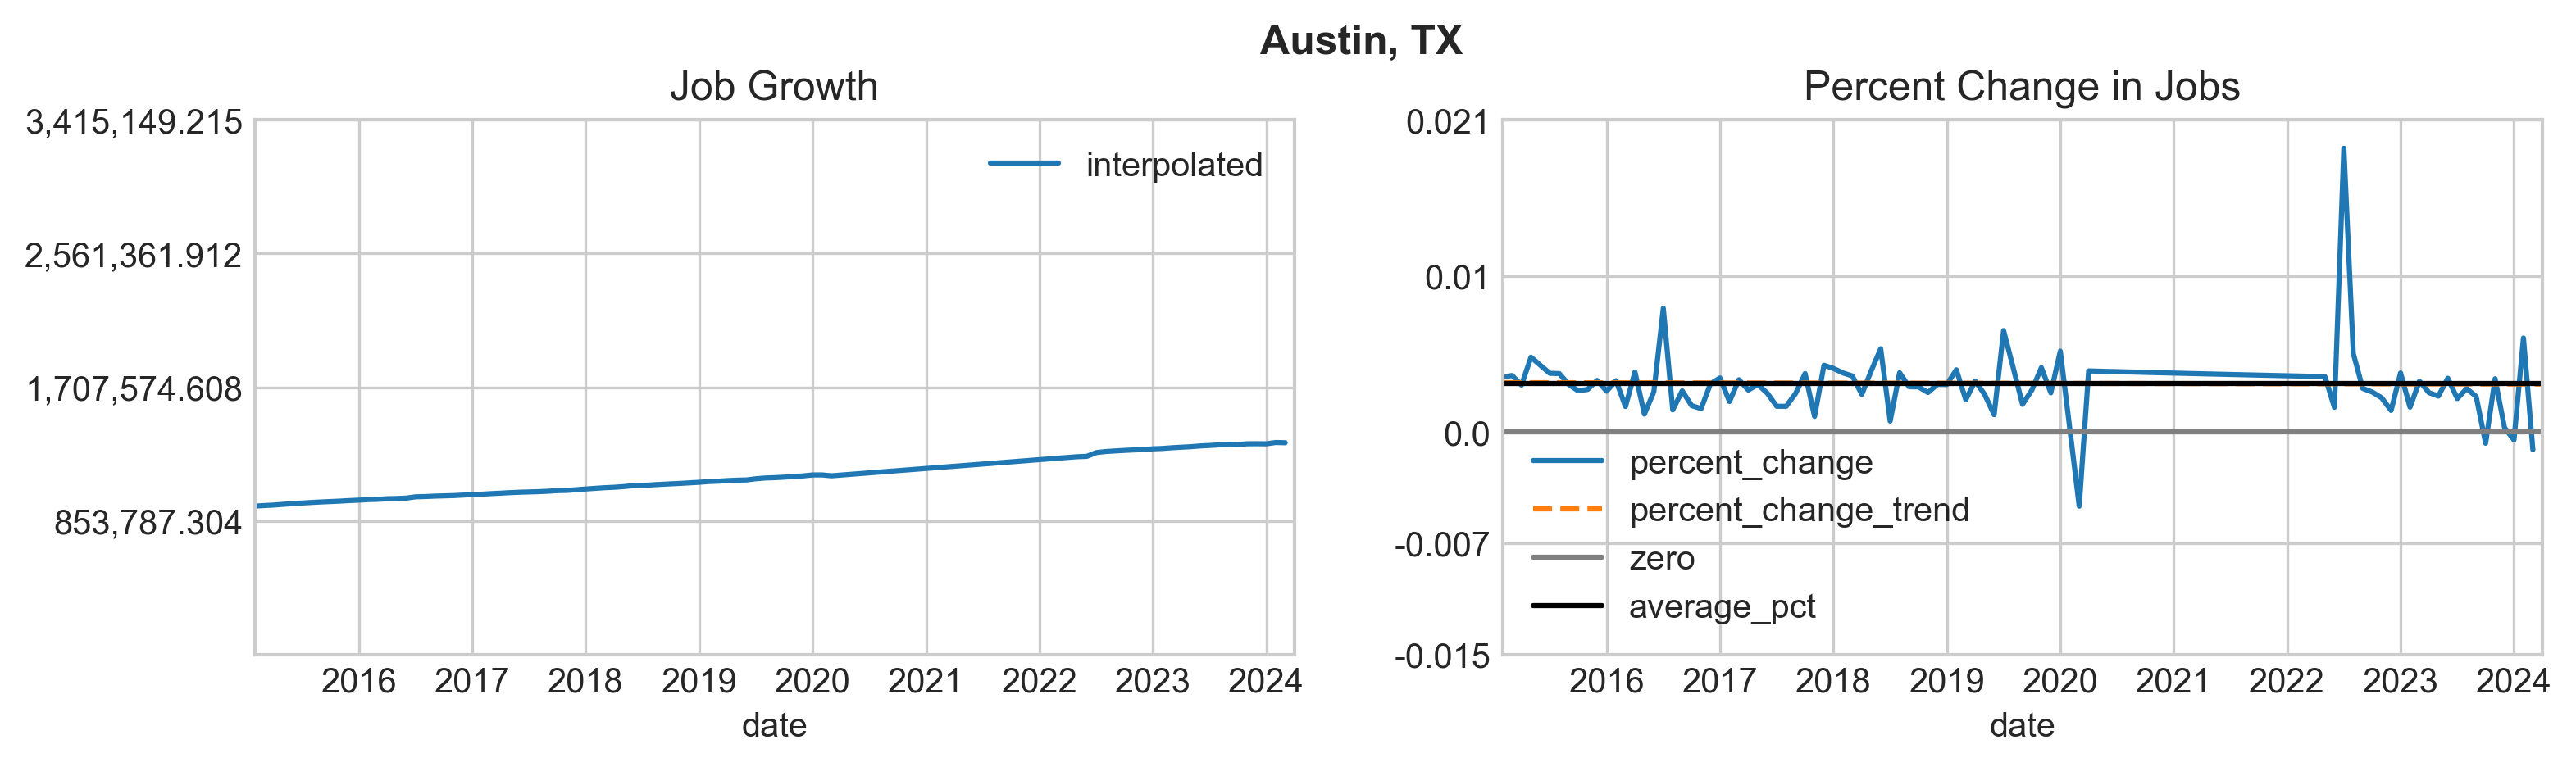

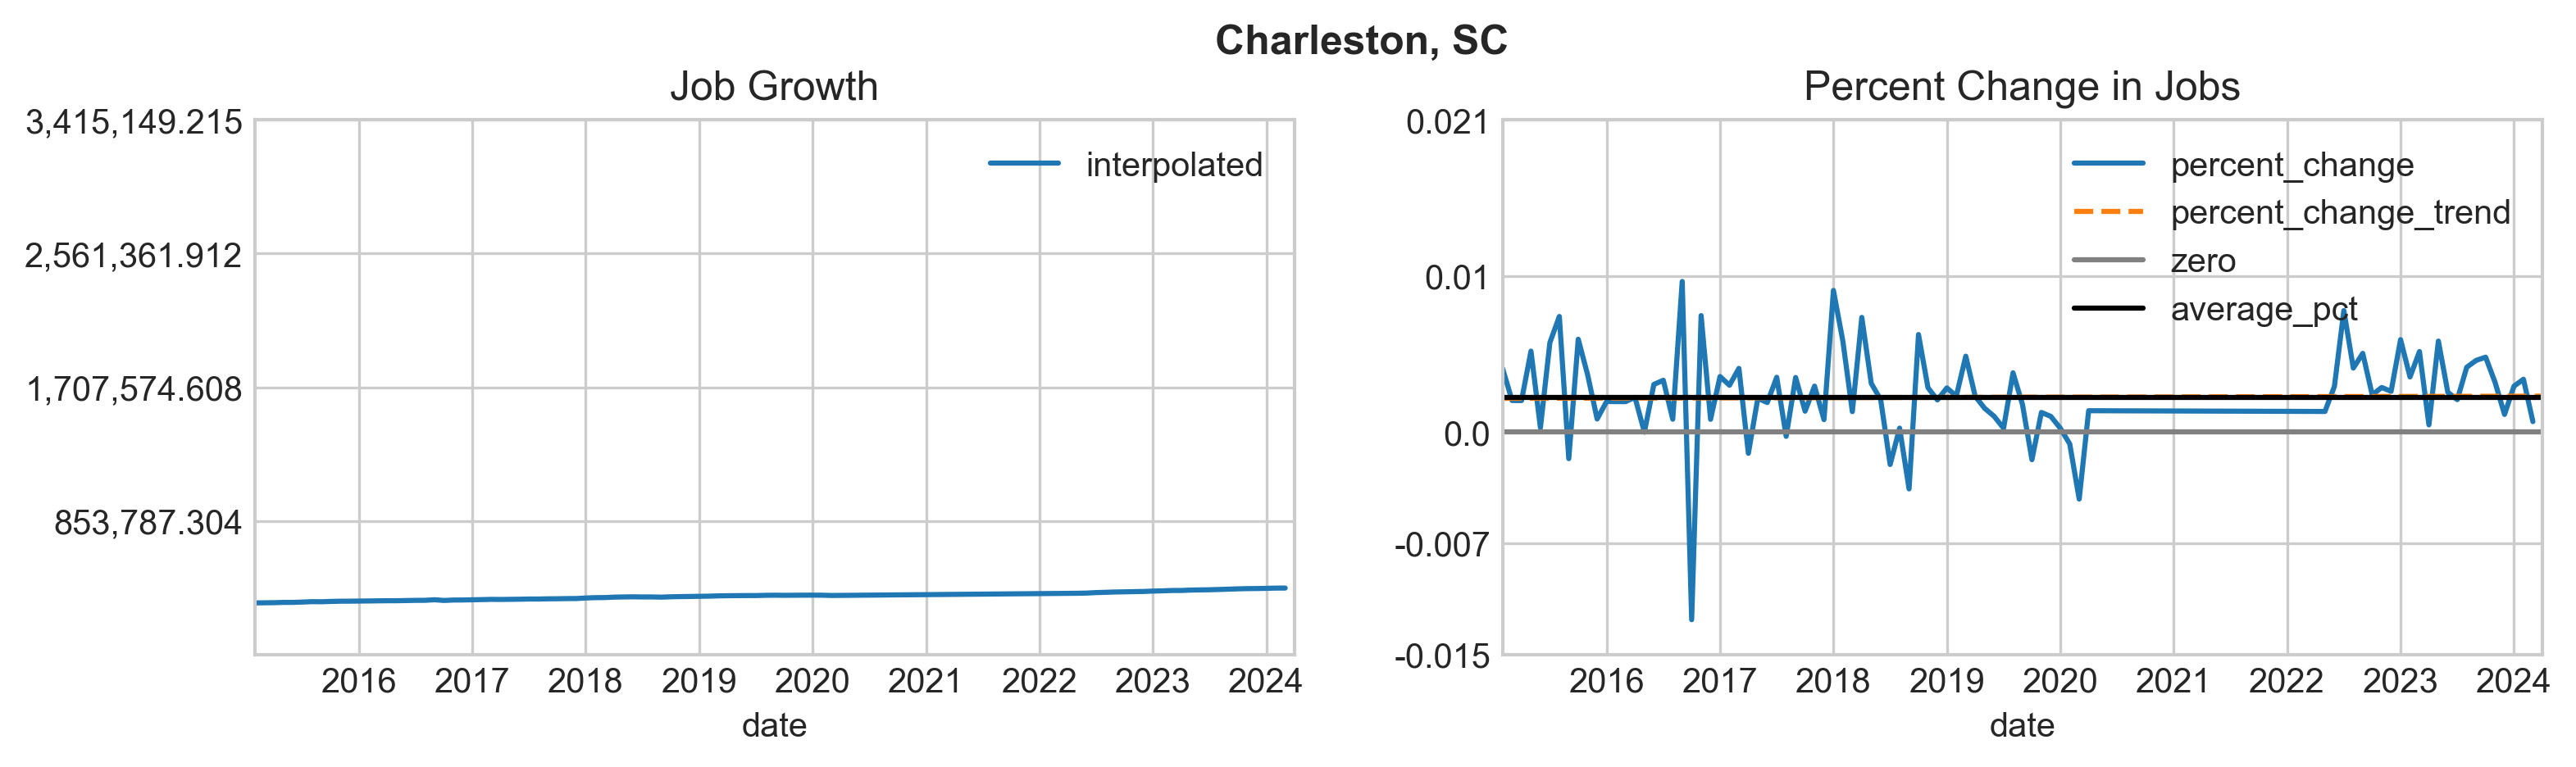

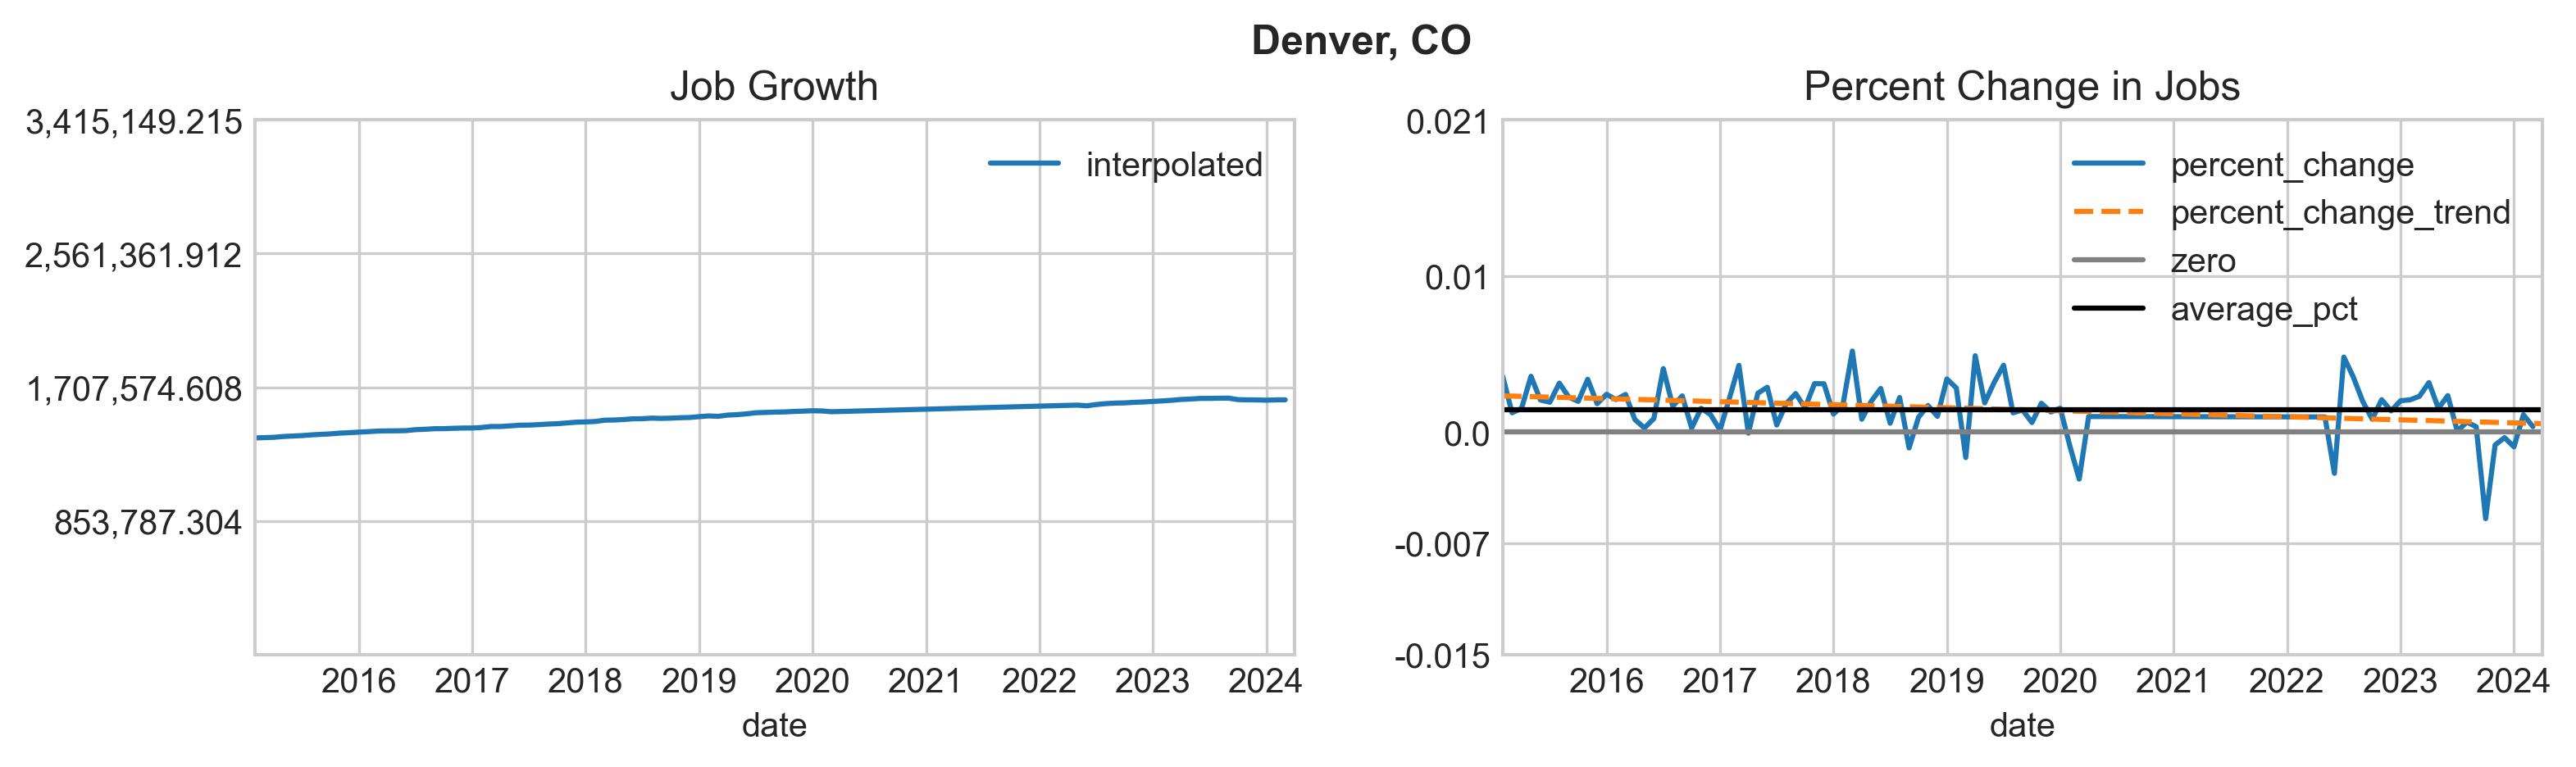

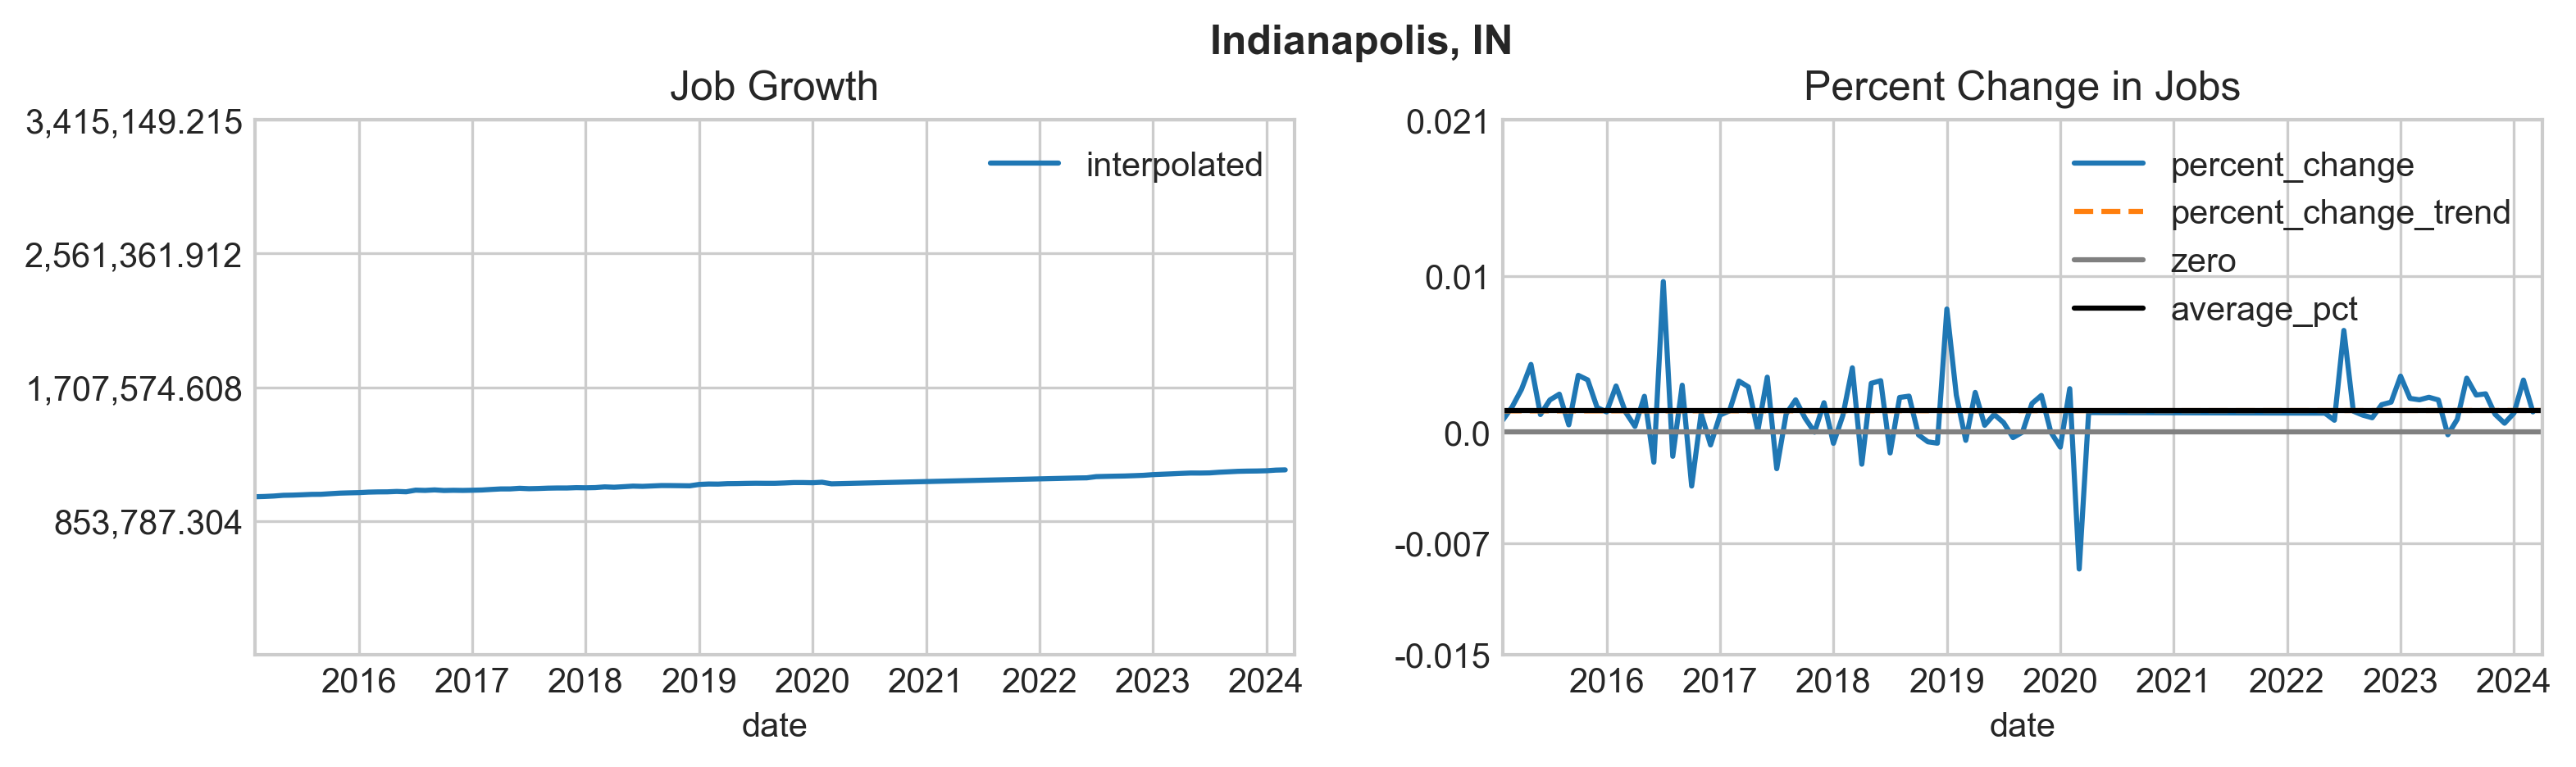

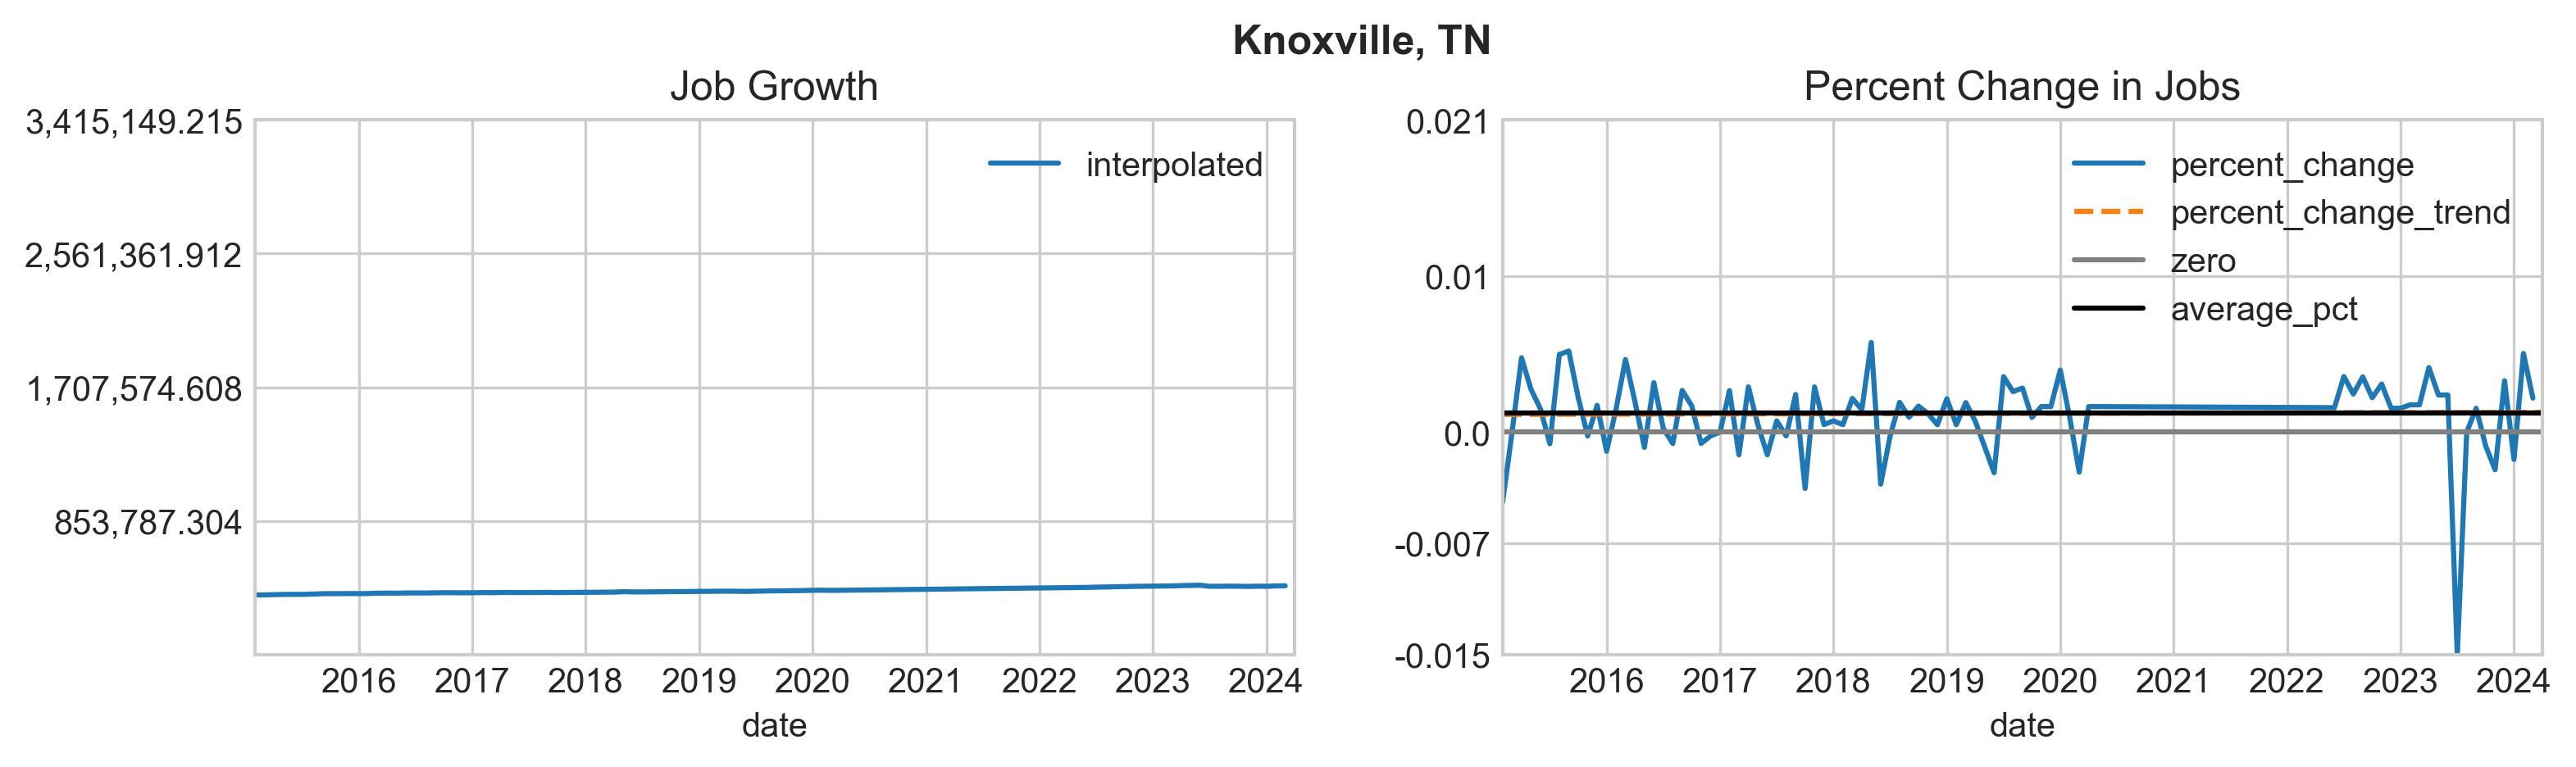

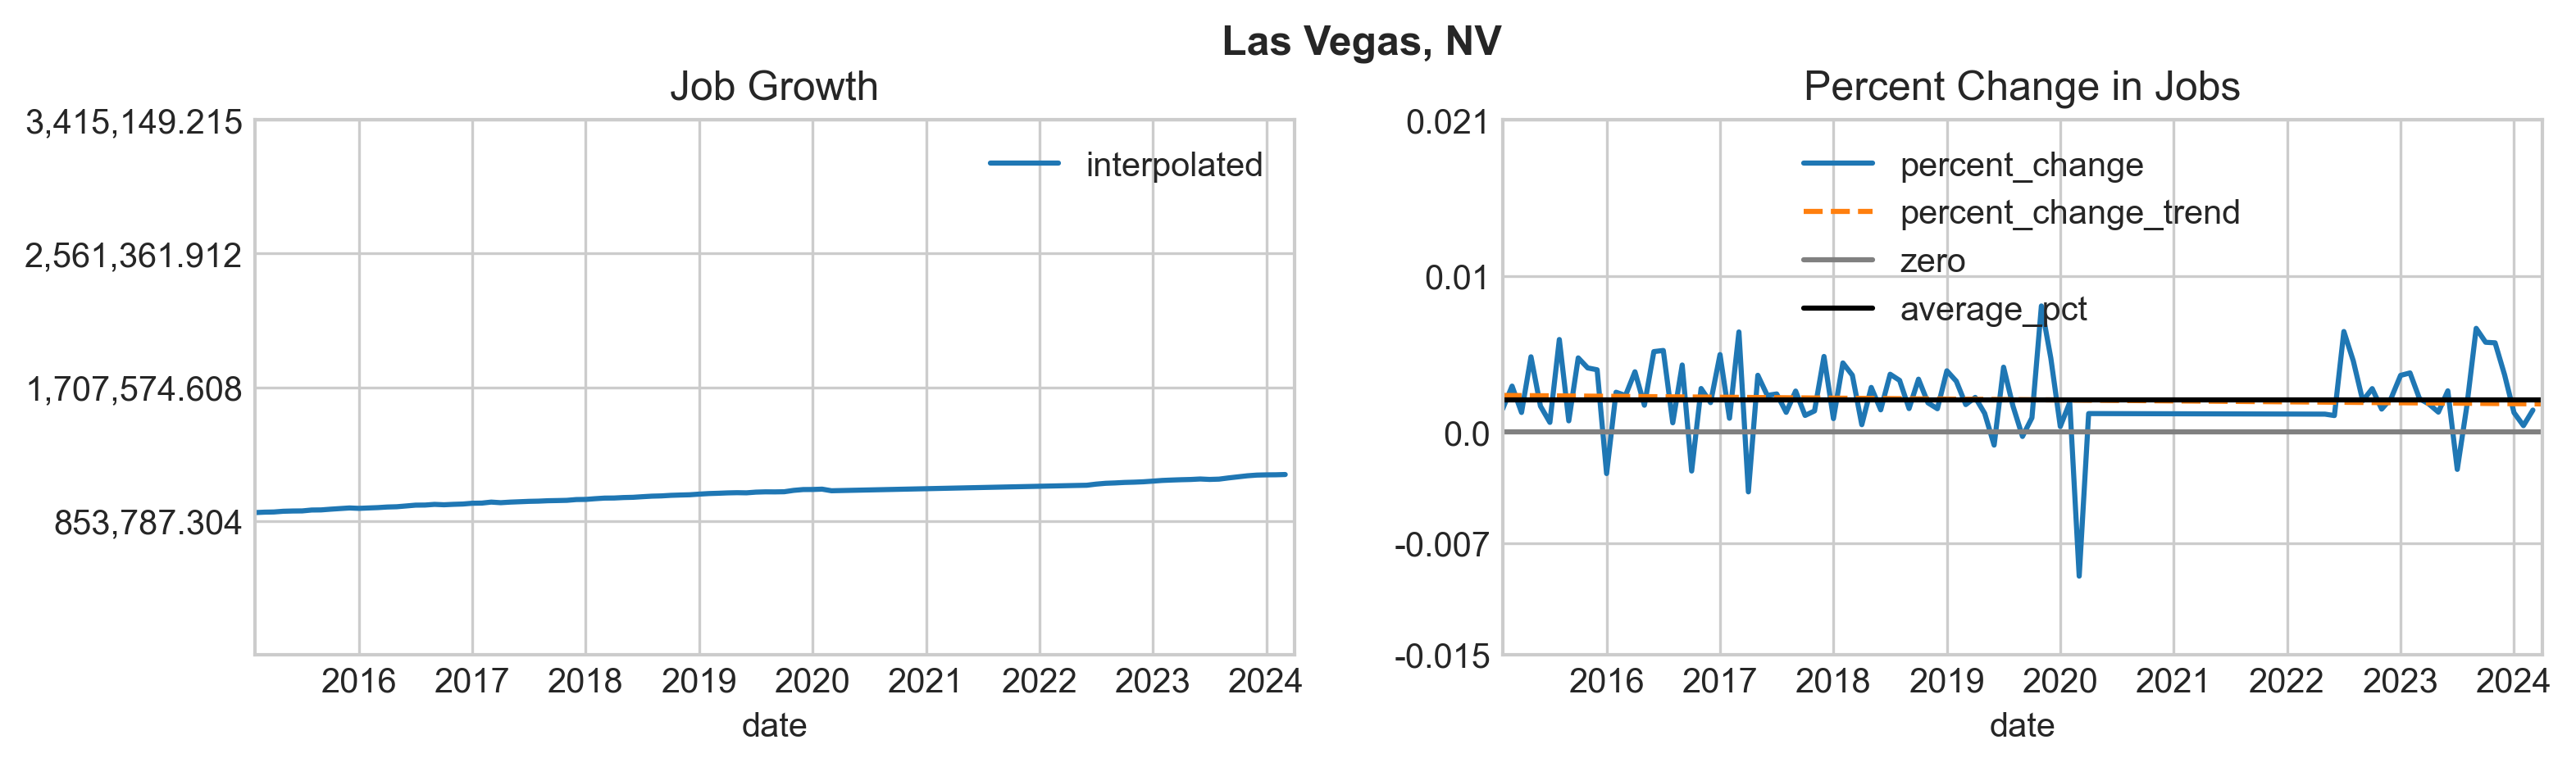

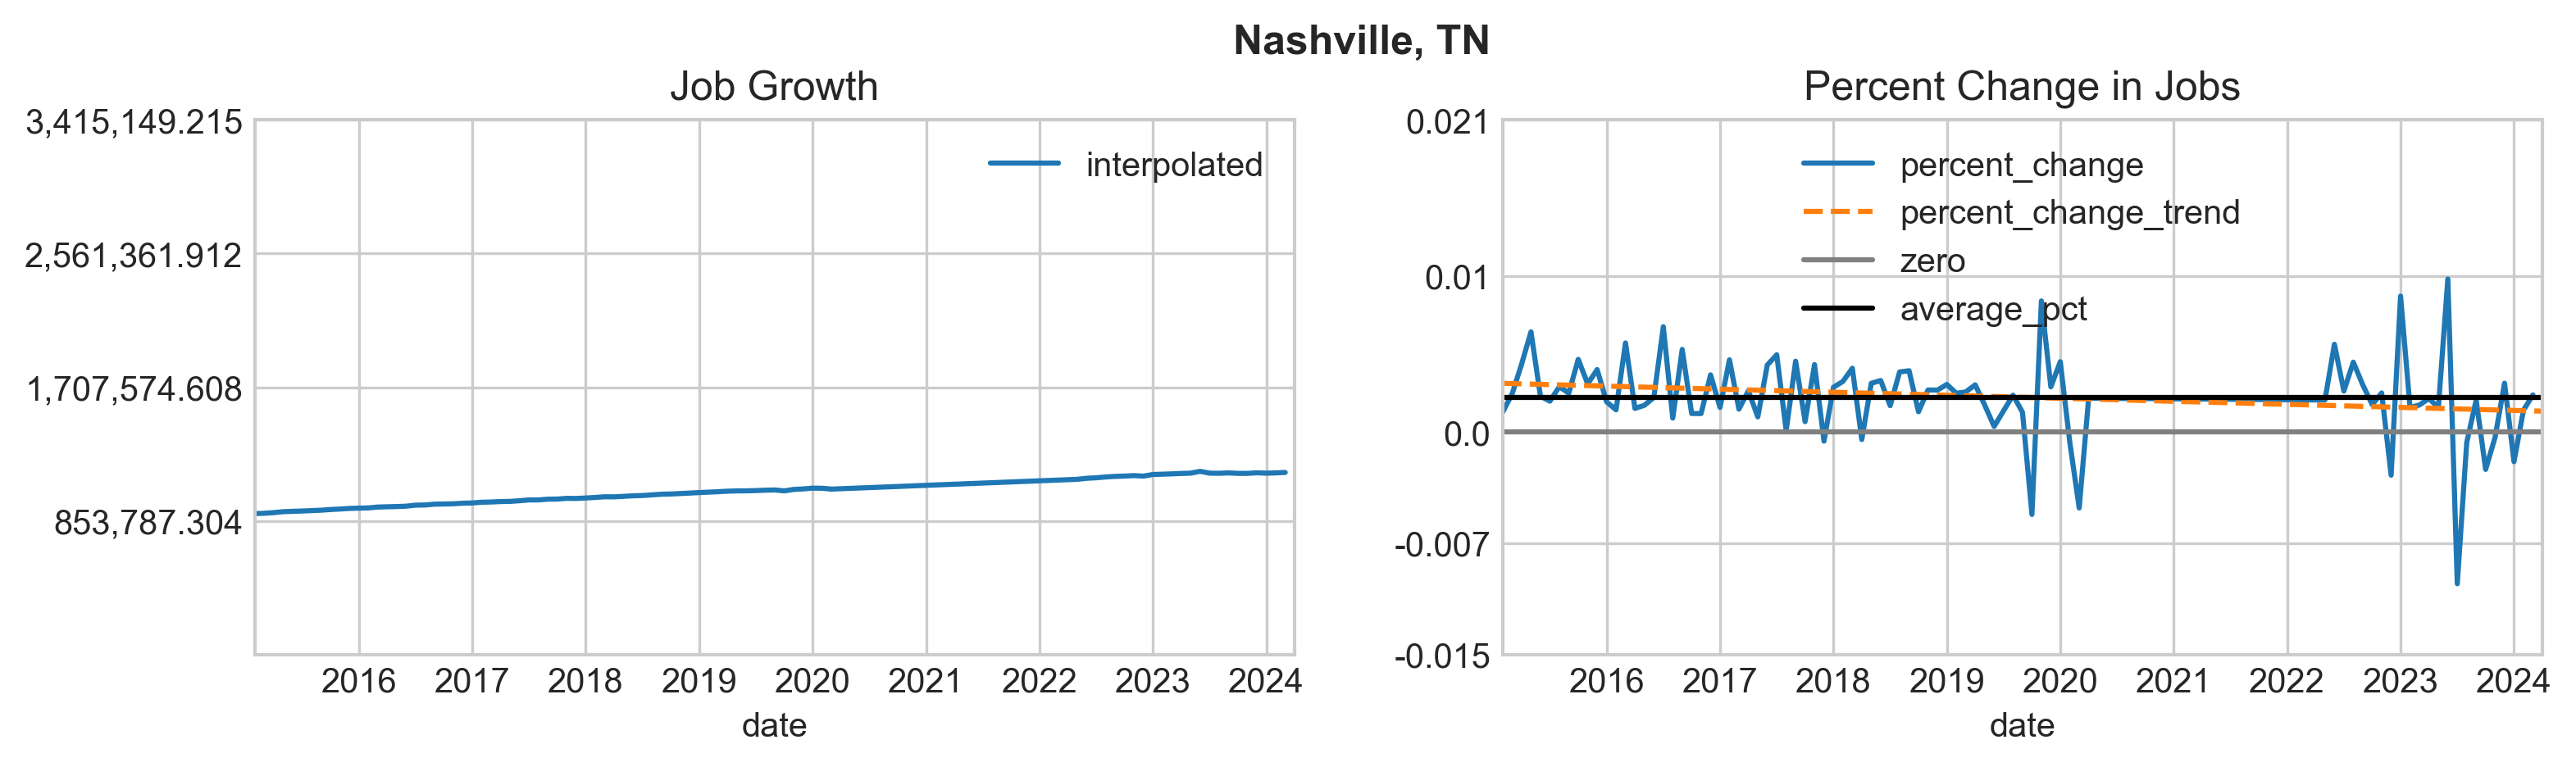

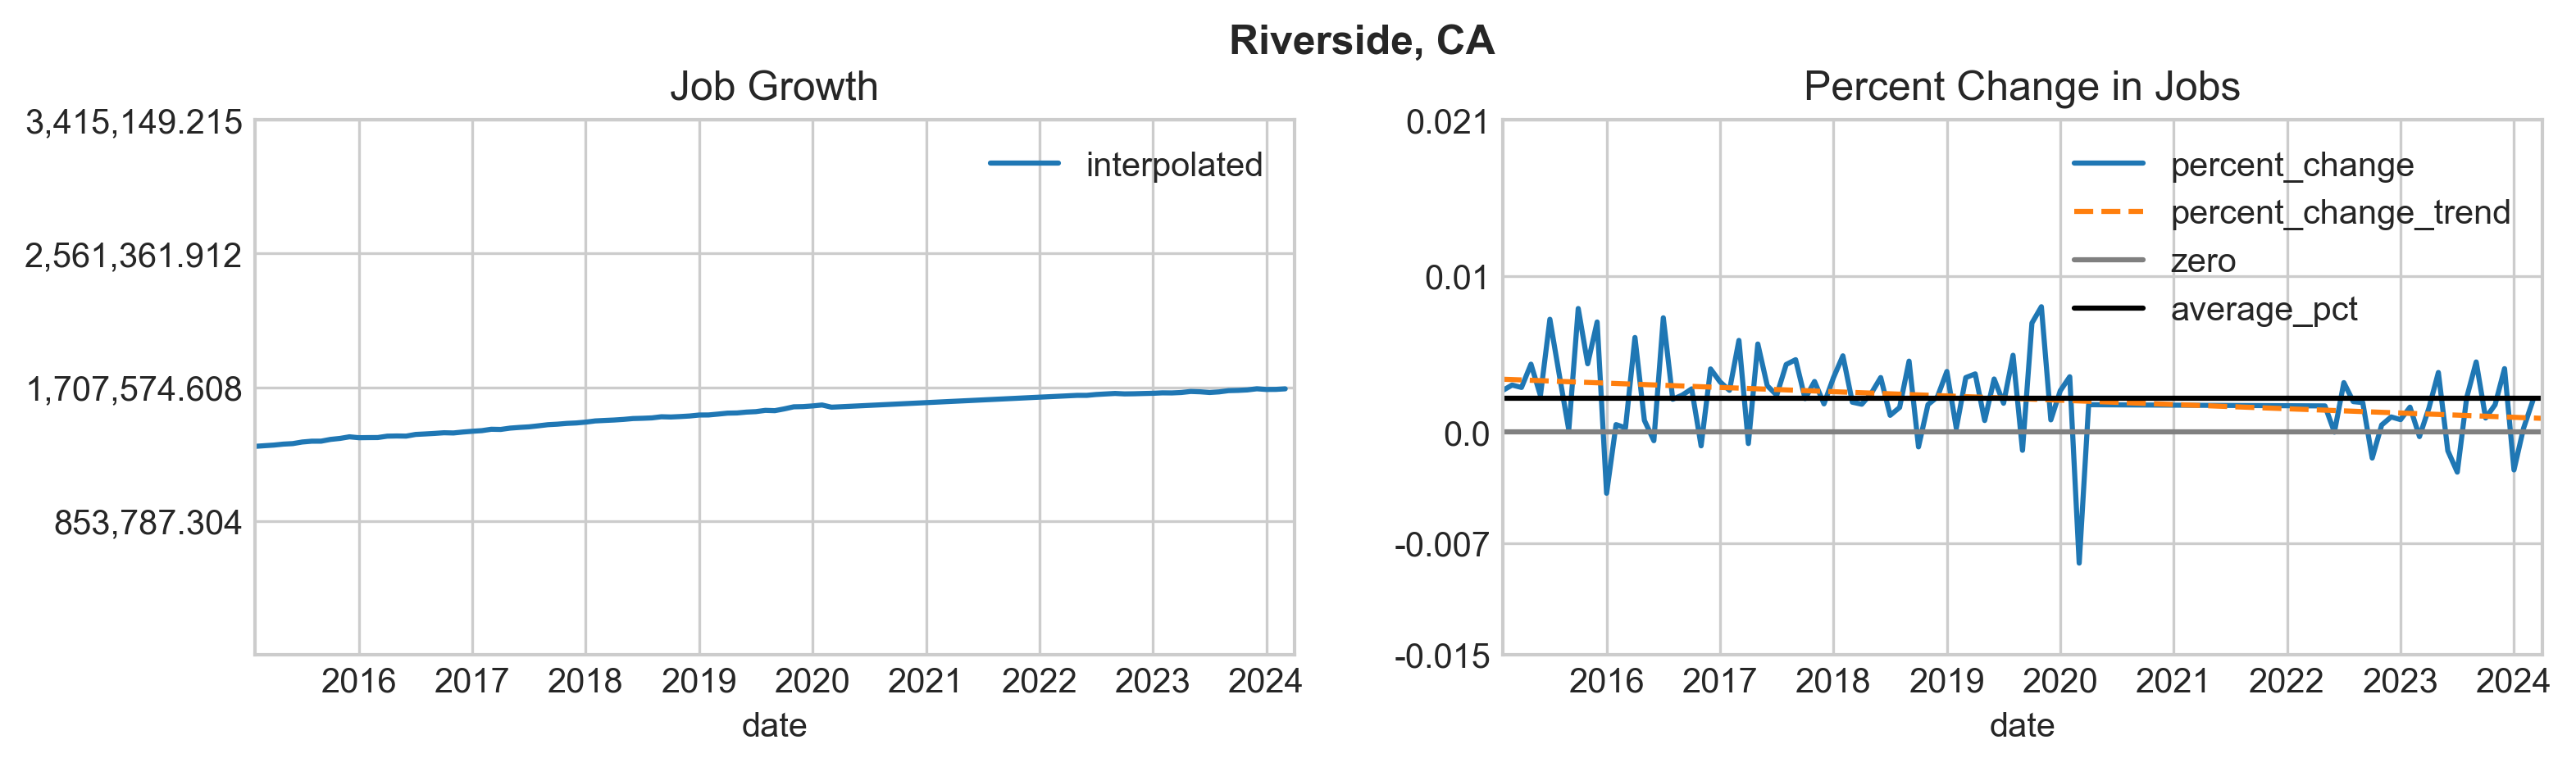

In [330]:
plot_top_10_cities(
    plot_these_jobs,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2015,
    end_year_1=2024,
    plot_all=True,
    column_to_use='interpolated'
)

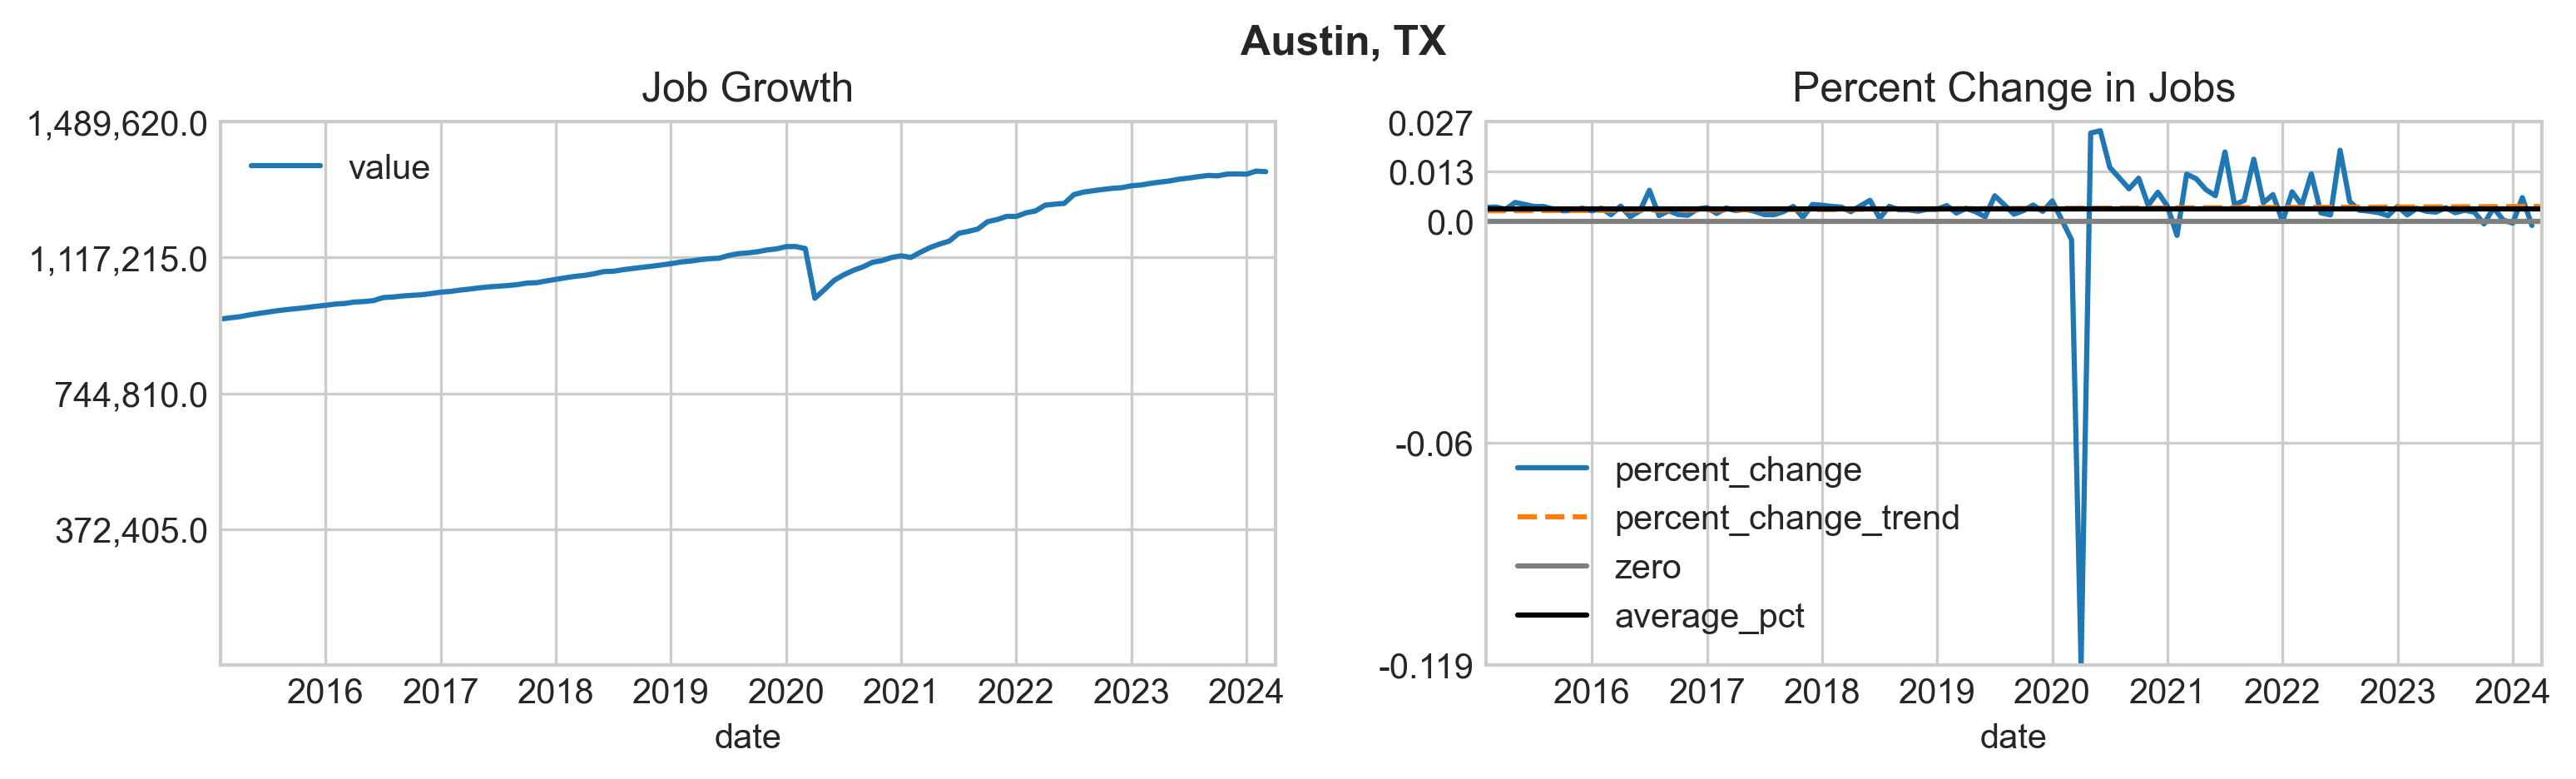

In [270]:
# Before Interpolation
before_example = plot_these_jobs[plot_these_jobs['msa_name'].str.contains(
    """Austin"""
)]

plot_top_10_cities(
    before_example,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2015,
    end_year_1=2024,
    plot_all=True,
    column_to_use='value'
)

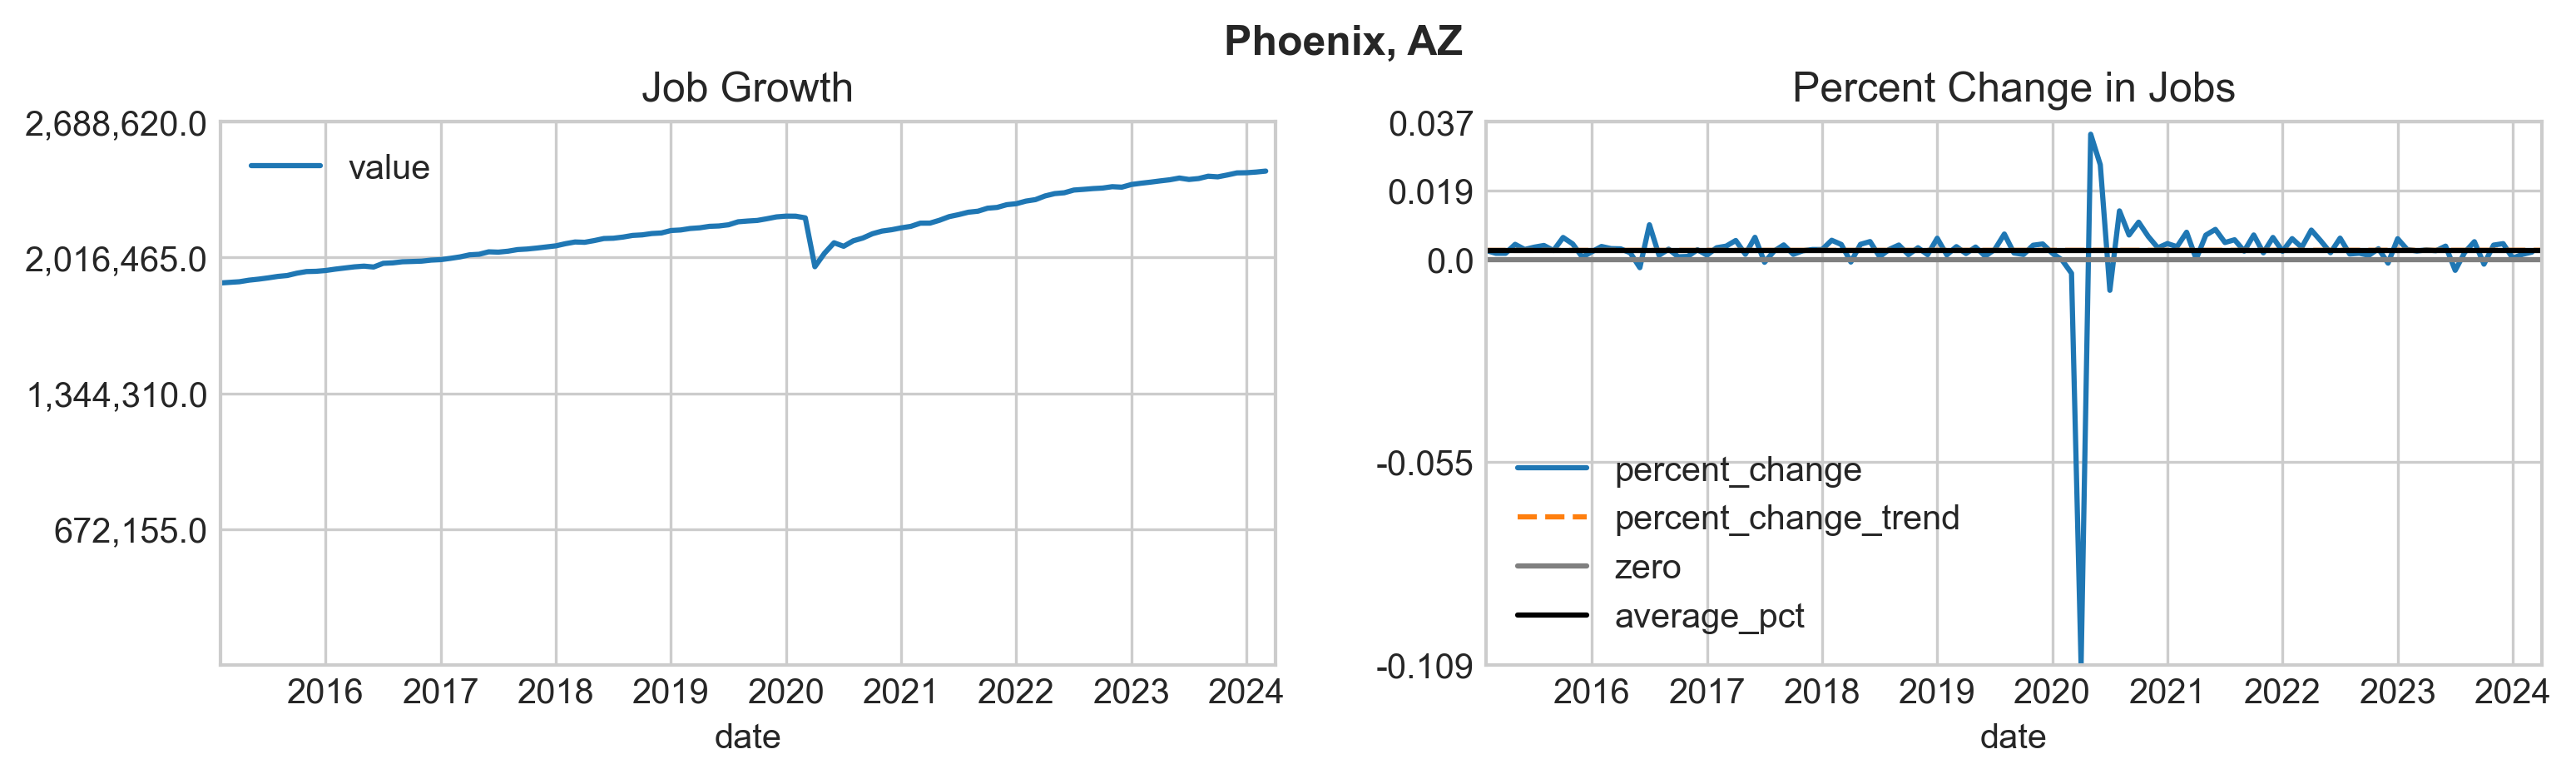

In [335]:
# Before Interpolation
before_example = plot_big_jobs[plot_big_jobs['msa_name'].str.contains(
    """Phoenix"""
)]

plot_top_10_cities(
    before_example,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2015,
    end_year_1=2024,
    plot_all=True,
    column_to_use='value'
)

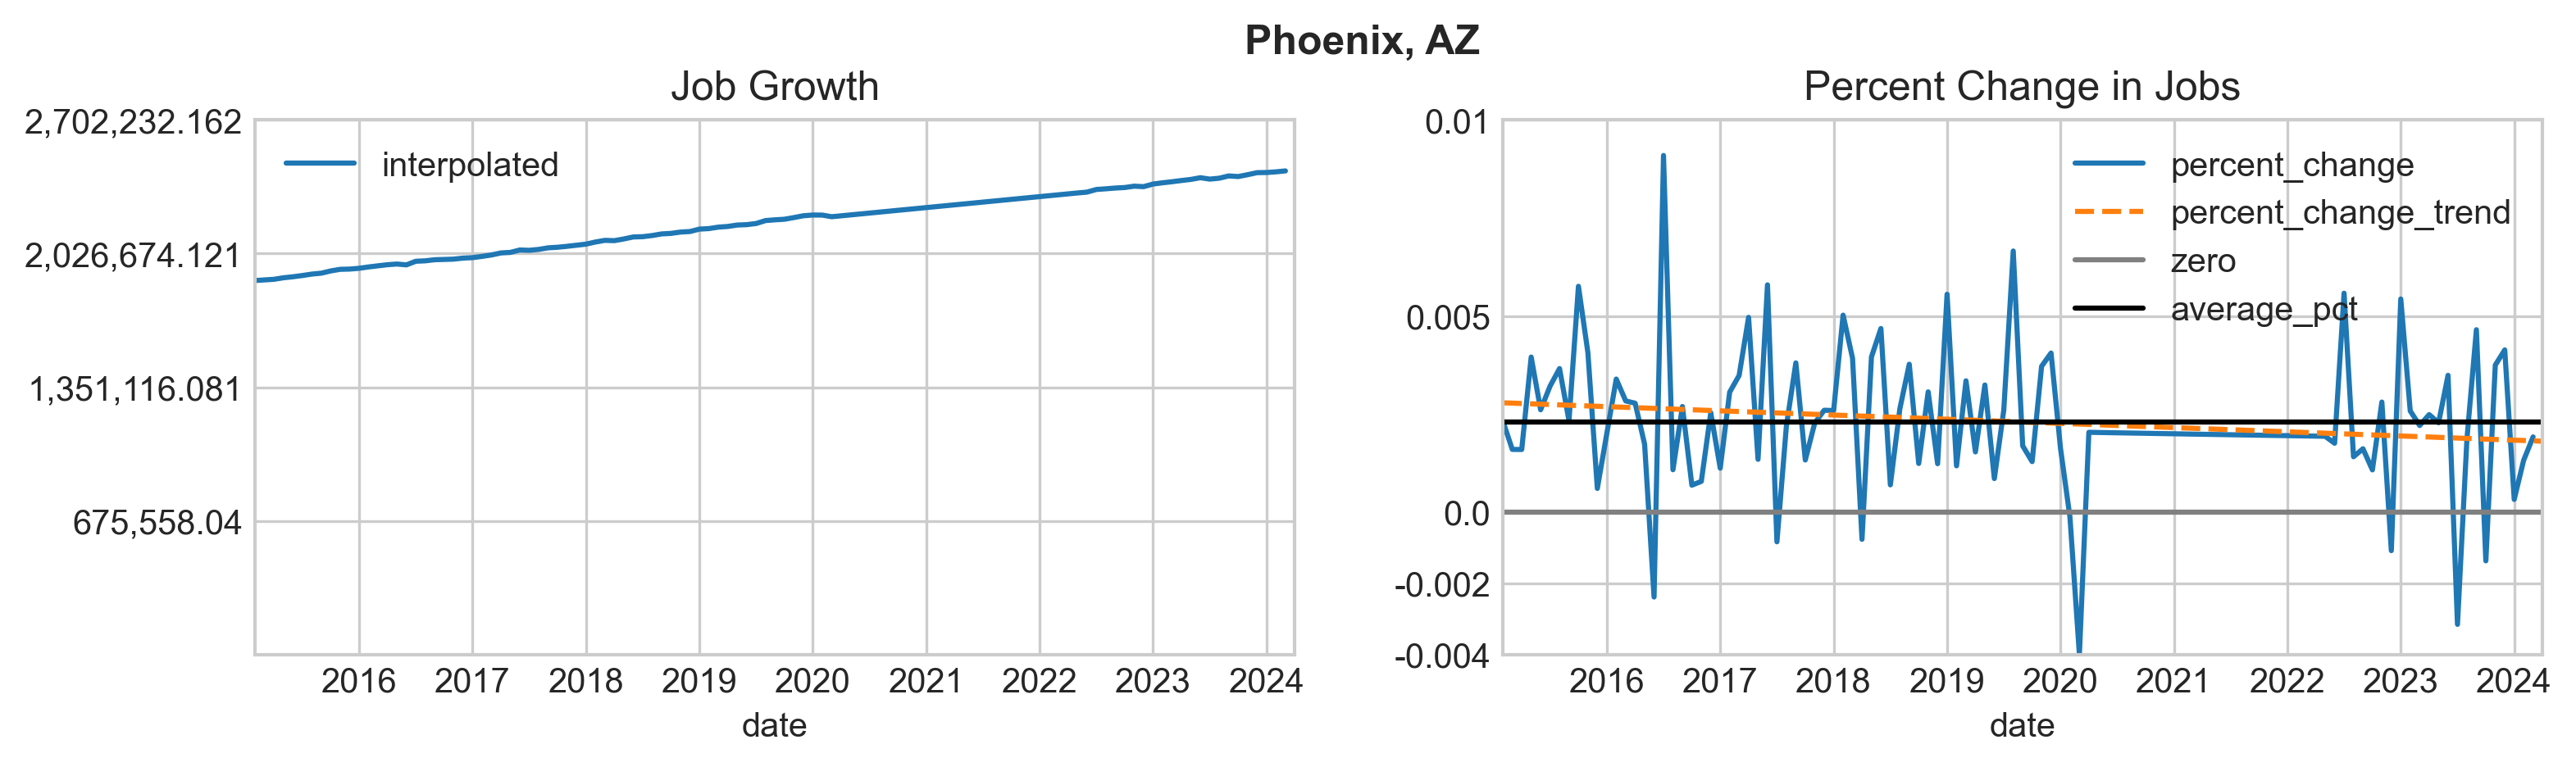

In [336]:
# After Interpolation
before_example = plot_big_jobs[plot_big_jobs['msa_name'].str.contains(
    """Phoenix"""
)]

plot_top_10_cities(
    before_example,
    plot_jobs=True,
    plot_rent=False,
    plot_income=False,
    plot_price=False,
    plot_units=False,
    plot_rent_to_price=False,
    plot_jobs_per_unit=False,
    using_zillow_data=False,
    plot_zillow_price=False,
    plot_zillow_rent=False,
    begin_year_1=2015,
    end_year_1=2024,
    plot_all=True,
    column_to_use='interpolated'
)

TO-DO: 
- Wrap the smoothing function into the same "downloading recent BLS" python program and ensure it works!
- Push this to github!
- Post this work on LinkedIn/Medium!
- Make a new post/workbook where we access all possible years